In [ ]:
!pip install wfdb
!pip install librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 138.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


Extracting ZIP file...
✓ Extraction complete!

Extracted files: ['103.xws', '103.hea', '232.hea', '103.atr', '233.hea', '117.xws', '223.hea', '112.hea', '205.xws', '207.dat']

Loading record: /content/mit-bih-arrhythmia-database-1.0.0/100
✓ Record loaded successfully!
  - Duration: 1805.6 seconds
  - Sampling rate: 360 Hz
  - Number of leads: 2
  - Lead names: ['MLII', 'V5']
  - Number of annotations: 2274


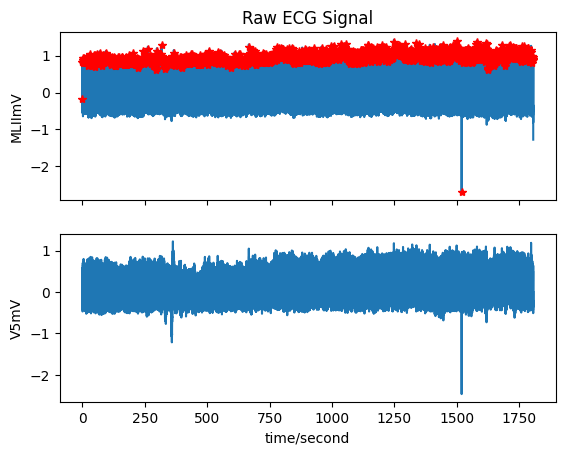

In [ ]:
import wfdb
import os
import matplotlib.pyplot as plt
import zipfile

# ============================================
# STEP 1: EXTRACT ZIP FILE
# ============================================
zip_path = '/content/mit-bih-arrhythmia-database-1.0.0.zip'
extract_path = '/content/'

print('Extracting ZIP file...')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print('✓ Extraction complete!')

# ============================================
# STEP 2: LIST EXTRACTED FILES
# ============================================
extracted_files = os.listdir('/content/mit-bih-arrhythmia-database-1.0.0')
print('\nExtracted files:', extracted_files[:10])  # Show first 10 files

# ============================================
# STEP 3: LOAD ECG RECORD
# ============================================
record_name = '/content/mit-bih-arrhythmia-database-1.0.0/100'
print(f'\nLoading record: {record_name}')

record = wfdb.rdrecord(record_name)
annotation = wfdb.rdann(record_name, 'atr')

print(f'✓ Record loaded successfully!')
print(f'  - Duration: {record.sig_len / record.fs:.1f} seconds')
print(f'  - Sampling rate: {record.fs} Hz')
print(f'  - Number of leads: {record.n_sig}')
print(f'  - Lead names: {record.sig_name}')
print(f'  - Number of annotations: {len(annotation.sample)}')

# ============================================
# STEP 4: PLOT ECG SIGNAL
# ============================================
wfdb.plot_wfdb(record=record, annotation=annotation, title='Raw ECG Signal')

📦 Extracting ZIP file...
✓ Extraction complete!

📊 Loading record: Patient 100
✓ Record loaded successfully!
  • Duration: 1805.6 seconds
  • Sampling rate: 360 Hz
  • Leads: ['MLII', 'V5']
  • Total beats annotated: 2274

🔬 PREPROCESSING PIPELINE

1️⃣ Removing baseline wander...
   ✓ Baseline wander removed (highpass 0.5 Hz)

2️⃣ Removing high-frequency noise...
   ✓ Noise filtered (bandpass 0.5-50 Hz)

3️⃣ Normalizing signal...
   ✓ Signal normalized (z-score)

4️⃣ Quality Metrics:
   • SNR: -4.50 dB
   • Raw signal range: [-2.715, 1.435] mV
   • Filtered range: [-2.450, 2.123] mV
   • Normalized range: [-13.231, 11.464]


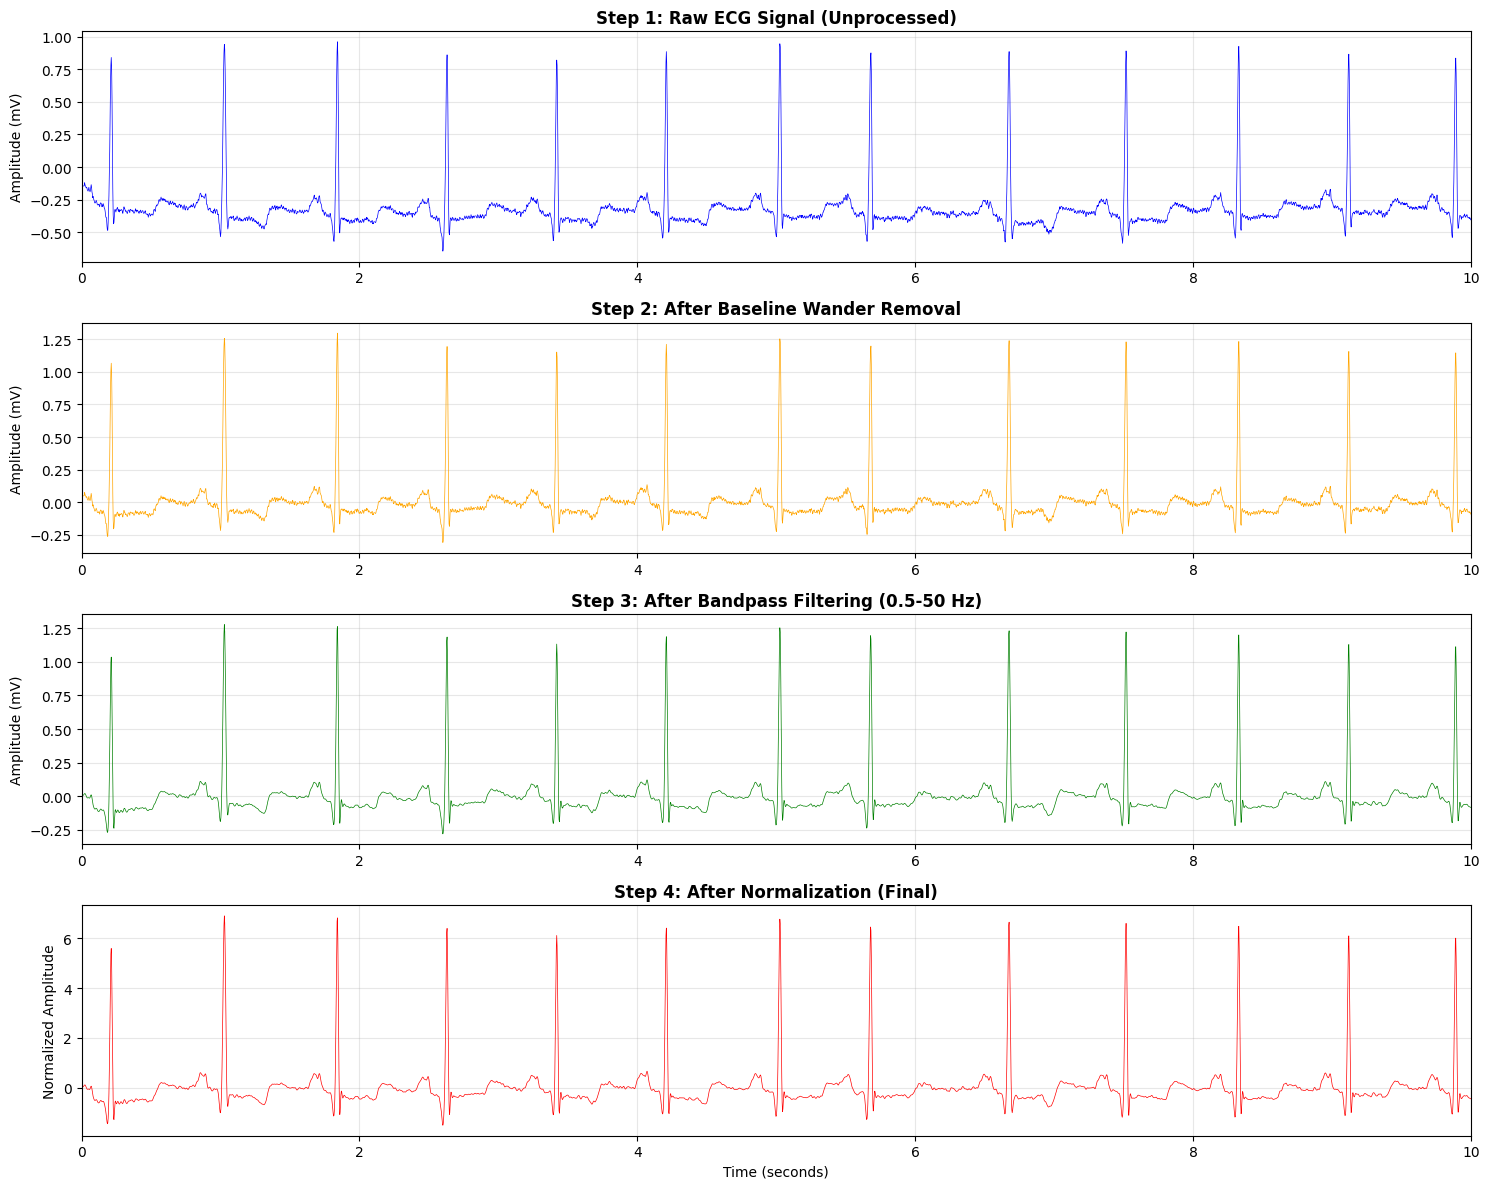

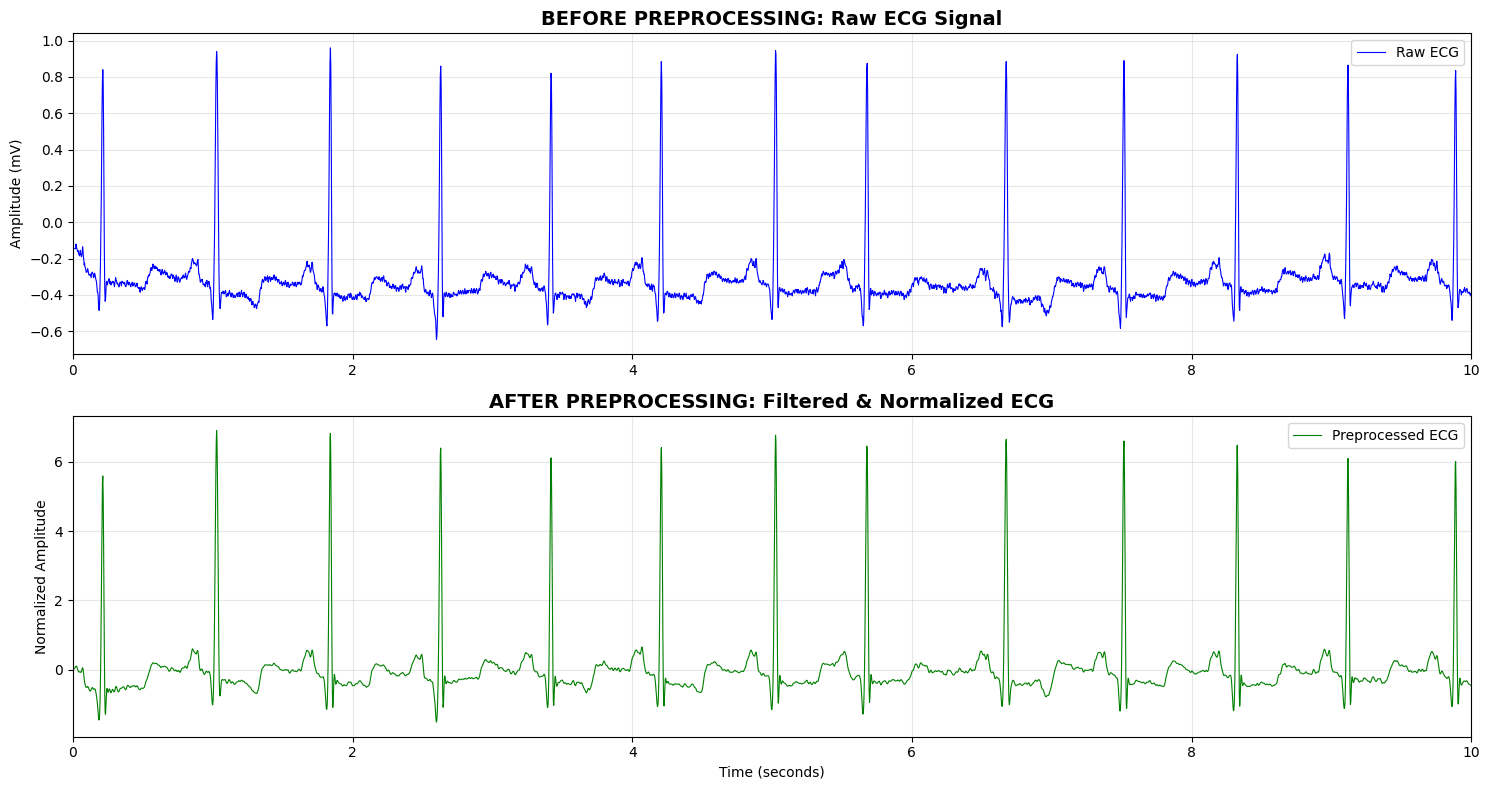

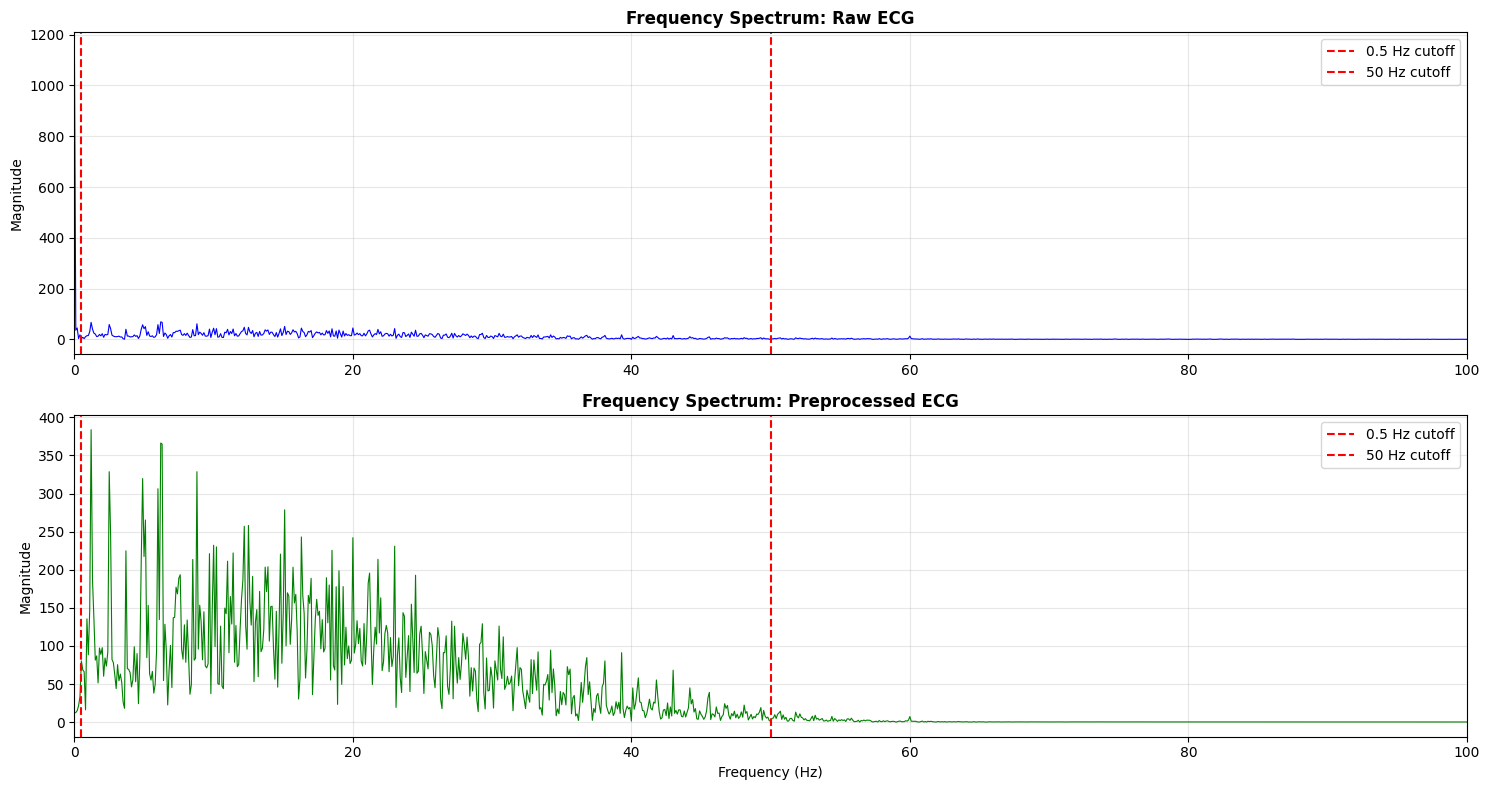


✅ PREPROCESSING COMPLETE!

📊 Ready for next steps:
   • R-peak detection
   • PQRST segmentation
   • Feature extraction
   • ML model training

💾 Preprocessed ECG stored in variable: preprocessed_ecg
   Shape: (650000,)
   Data type: float64


In [ ]:
import wfdb
import os
import matplotlib.pyplot as plt
import zipfile
import numpy as np
from scipy.signal import butter, filtfilt

# ============================================
# STEP 1: EXTRACT ZIP FILE
# ============================================
zip_path = '/content/mit-bih-arrhythmia-database-1.0.0.zip'
extract_path = '/content/'

print('📦 Extracting ZIP file...')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print('✓ Extraction complete!\n')

# ============================================
# STEP 2: LOAD ECG RECORD
# ============================================
record_name = '/content/mit-bih-arrhythmia-database-1.0.0/100'
print(f'📊 Loading record: Patient 100')

record = wfdb.rdrecord(record_name)
annotation = wfdb.rdann(record_name, 'atr')

print(f'✓ Record loaded successfully!')
print(f'  • Duration: {record.sig_len / record.fs:.1f} seconds')
print(f'  • Sampling rate: {record.fs} Hz')
print(f'  • Leads: {record.sig_name}')
print(f'  • Total beats annotated: {len(annotation.sample)}\n')

# ============================================
# STEP 3: PREPROCESSING FUNCTIONS
# ============================================

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Bandpass filter to remove both low-frequency baseline wander
    and high-frequency noise
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def remove_baseline_wander(data, fs, cutoff=0.5, order=3):
    """
    Highpass filter to remove baseline wander (breathing, movement)
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high')
    y = filtfilt(b, a, data)
    return y

def normalize_signal(data):
    """
    Z-score normalization: (x - mean) / std
    Centers signal around 0 with std = 1
    """
    mean = np.mean(data)
    std = np.std(data)
    normalized = (data - mean) / std
    return normalized

def calculate_snr(original, filtered):
    """
    Calculate Signal-to-Noise Ratio in dB
    """
    noise = original - filtered
    signal_power = np.mean(filtered ** 2)
    noise_power = np.mean(noise ** 2)

    if noise_power == 0:
        return float('inf')

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# ============================================
# STEP 4: EXTRACT RAW SIGNAL
# ============================================
raw_ecg = record.p_signal[:, 0]  # MLII lead
sampling_frequency = record.fs

print('🔬 PREPROCESSING PIPELINE')
print('=' * 50)

# ============================================
# STEP 5: APPLY PREPROCESSING
# ============================================

# Step 5.1: Remove baseline wander (highpass filter)
print('\n1️⃣ Removing baseline wander...')
ecg_no_baseline = remove_baseline_wander(raw_ecg, sampling_frequency, cutoff=0.5)
print('   ✓ Baseline wander removed (highpass 0.5 Hz)')

# Step 5.2: Remove high-frequency noise (lowpass filter)
print('\n2️⃣ Removing high-frequency noise...')
ecg_filtered = butter_bandpass_filter(raw_ecg, lowcut=0.5, highcut=50.0,
                                      fs=sampling_frequency, order=5)
print('   ✓ Noise filtered (bandpass 0.5-50 Hz)')

# Step 5.3: Normalize the signal
print('\n3️⃣ Normalizing signal...')
ecg_normalized = normalize_signal(ecg_filtered)
print('   ✓ Signal normalized (z-score)')

# Step 5.4: Calculate quality metrics
print('\n4️⃣ Quality Metrics:')
snr_value = calculate_snr(raw_ecg, ecg_filtered)
print(f'   • SNR: {snr_value:.2f} dB')
print(f'   • Raw signal range: [{raw_ecg.min():.3f}, {raw_ecg.max():.3f}] mV')
print(f'   • Filtered range: [{ecg_filtered.min():.3f}, {ecg_filtered.max():.3f}] mV')
print(f'   • Normalized range: [{ecg_normalized.min():.3f}, {ecg_normalized.max():.3f}]')

# ============================================
# STEP 6: VISUALIZATION
# ============================================

# Create figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Define time axis (first 10 seconds for clarity)
display_duration = 10  # seconds
display_samples = int(display_duration * sampling_frequency)
time_axis = np.arange(display_samples) / sampling_frequency

# Plot 1: Raw ECG
axes[0].plot(time_axis, raw_ecg[:display_samples], color='blue', linewidth=0.5)
axes[0].set_title('Step 1: Raw ECG Signal (Unprocessed)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude (mV)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, display_duration])

# Plot 2: After Baseline Removal
axes[1].plot(time_axis, ecg_no_baseline[:display_samples], color='orange', linewidth=0.5)
axes[1].set_title('Step 2: After Baseline Wander Removal', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Amplitude (mV)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, display_duration])

# Plot 3: After Full Filtering
axes[2].plot(time_axis, ecg_filtered[:display_samples], color='green', linewidth=0.5)
axes[2].set_title('Step 3: After Bandpass Filtering (0.5-50 Hz)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Amplitude (mV)')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([0, display_duration])

# Plot 4: After Normalization
axes[3].plot(time_axis, ecg_normalized[:display_samples], color='red', linewidth=0.5)
axes[3].set_title('Step 4: After Normalization (Final)', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Time (seconds)')
axes[3].set_ylabel('Normalized Amplitude')
axes[3].grid(True, alpha=0.3)
axes[3].set_xlim([0, display_duration])

plt.tight_layout()
plt.show()

# ============================================
# STEP 7: COMPARISON VIEW (Before vs After)
# ============================================

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Before preprocessing
axes[0].plot(time_axis, raw_ecg[:display_samples], color='blue', linewidth=0.8, label='Raw ECG')
axes[0].set_title('BEFORE PREPROCESSING: Raw ECG Signal', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Amplitude (mV)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, display_duration])

# After preprocessing
axes[1].plot(time_axis, ecg_normalized[:display_samples], color='green', linewidth=0.8, label='Preprocessed ECG')
axes[1].set_title('AFTER PREPROCESSING: Filtered & Normalized ECG', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Normalized Amplitude')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, display_duration])

plt.tight_layout()
plt.show()

# ============================================
# STEP 8: FREQUENCY DOMAIN ANALYSIS
# ============================================

from scipy.fft import fft, fftfreq

# Compute FFT
fft_raw = np.abs(fft(raw_ecg[:display_samples]))
fft_filtered = np.abs(fft(ecg_normalized[:display_samples]))
freqs = fftfreq(display_samples, 1/sampling_frequency)

# Plot frequency spectrum
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Raw signal spectrum
axes[0].plot(freqs[:display_samples//2], fft_raw[:display_samples//2], color='blue', linewidth=0.8)
axes[0].set_title('Frequency Spectrum: Raw ECG', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Magnitude')
axes[0].set_xlim([0, 100])  # Show up to 100 Hz
axes[0].axvline(x=0.5, color='red', linestyle='--', label='0.5 Hz cutoff')
axes[0].axvline(x=50, color='red', linestyle='--', label='50 Hz cutoff')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Filtered signal spectrum
axes[1].plot(freqs[:display_samples//2], fft_filtered[:display_samples//2], color='green', linewidth=0.8)
axes[1].set_title('Frequency Spectrum: Preprocessed ECG', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].set_xlim([0, 100])
axes[1].axvline(x=0.5, color='red', linestyle='--', label='0.5 Hz cutoff')
axes[1].axvline(x=50, color='red', linestyle='--', label='50 Hz cutoff')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# ============================================
# STEP 9: SAVE PREPROCESSED DATA
# ============================================

print('\n' + '=' * 50)
print('✅ PREPROCESSING COMPLETE!')
print('=' * 50)
print('\n📊 Ready for next steps:')
print('   • R-peak detection')
print('   • PQRST segmentation')
print('   • Feature extraction')
print('   • ML model training')

# Store preprocessed data for later use
preprocessed_ecg = ecg_normalized
print(f'\n💾 Preprocessed ECG stored in variable: preprocessed_ecg')
print(f'   Shape: {preprocessed_ecg.shape}')
print(f'   Data type: {preprocessed_ecg.dtype}')

In [ ]:
'''
import numpy as np
from scipy.signal import butter, filtfilt

# Butterworth filter function for noise removal
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Parameters for the lowpass filter
cutoff_frequency = 50.0  # Hz
sampling_frequency = record.fs  # Sampling frequency from the record

# Apply the filter to the ECG signal
filtered_ecg_waveform = butter_lowpass_filter(record.p_signal[:, 0], cutoff_frequency, sampling_frequency)

# Plot the filtered ECG data
plt.figure(figsize=(14, 5))
plt.plot(filtered_ecg_waveform, label='Filtered ECG Waveform', color='green')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.title('Filtered ECG Waveform')
plt.legend()
plt.show()
'''

"\nimport numpy as np\nfrom scipy.signal import butter, filtfilt\n\n# Butterworth filter function for noise removal\ndef butter_lowpass_filter(data, cutoff, fs, order=5):\n    nyquist = 0.5 * fs\n    normal_cutoff = cutoff / nyquist\n    b, a = butter(order, normal_cutoff, btype='low', analog=False)\n    y = filtfilt(b, a, data)\n    return y\n\n# Parameters for the lowpass filter\ncutoff_frequency = 50.0  # Hz\nsampling_frequency = record.fs  # Sampling frequency from the record\n\n# Apply the filter to the ECG signal\nfiltered_ecg_waveform = butter_lowpass_filter(record.p_signal[:, 0], cutoff_frequency, sampling_frequency)\n\n# Plot the filtered ECG data\nplt.figure(figsize=(14, 5))\nplt.plot(filtered_ecg_waveform, label='Filtered ECG Waveform', color='green')\nplt.xlabel('Sample Number')\nplt.ylabel('Amplitude')\nplt.title('Filtered ECG Waveform')\nplt.legend()\nplt.show()\n"

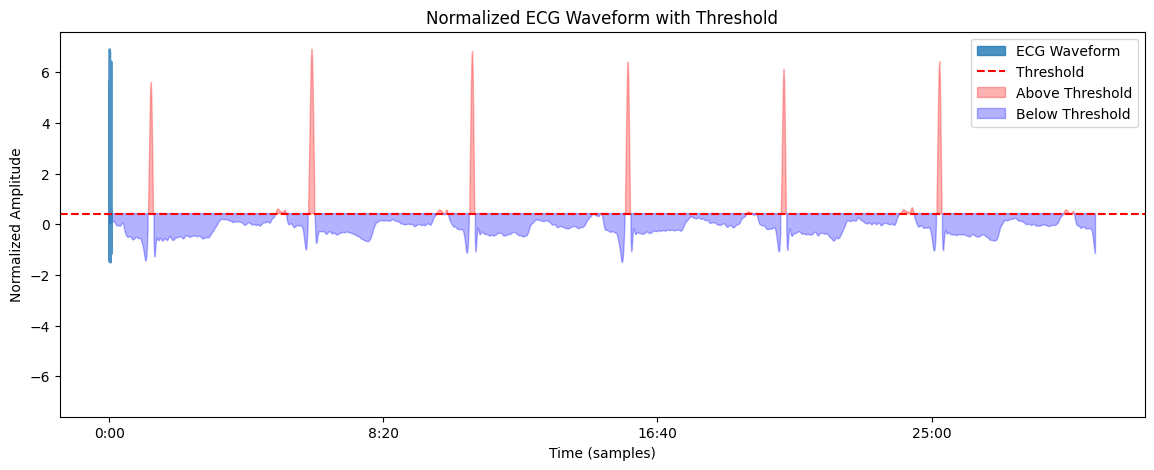

In [ ]:
import librosa.display

# Choose a segment of the ECG signal to plot (e.g., first 5 seconds)
num_seconds = 5
segment_length = int(num_seconds * sampling_frequency)
ecg_segment = ecg_normalized[:segment_length]

# Define the threshold such that P and T wave peaks are below it and R peak is above it
threshold = 0.42  # Adjust this threshold as needed

plt.figure(figsize=(14, 5))
librosa.display.waveshow(ecg_segment, sr=sampling_frequency, alpha=0.8, label='ECG Waveform')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

above_threshold = ecg_segment > threshold
below_threshold = ecg_segment < threshold

plt.fill_between(np.arange(len(ecg_segment)), ecg_segment, threshold, where=above_threshold, color='red', alpha=0.3, label='Above Threshold')
plt.fill_between(np.arange(len(ecg_segment)), ecg_segment, threshold, where=below_threshold, color='blue', alpha=0.3, label='Below Threshold')

plt.xlabel('Time (samples)')
plt.ylabel('Normalized Amplitude')
plt.title('Normalized ECG Waveform with Threshold')
plt.legend()
plt.show()

**Adavanced Methods**

🔍 R-PEAK DETECTION

📊 Analyzing first 5 seconds:
  • Segment length: 1800 samples
  • Signal range: [-1.515, 6.901]

📈 Adaptive Thresholding:
  • Signal mean: -0.022
  • Signal std: 0.876
  • Signal max: 6.901
  • Adaptive threshold: 2.401

✓ R-peaks detected: 6 beats
  • Average heart rate: 72.0 BPM
  • Peak locations (samples): [77, 370, 663, 947, 1231, 1515]

📊 Peak Statistics:
  • Mean peak height: 6.372
  • Peak height range: [5.591, 6.901]
  • Mean prominence: 7.572


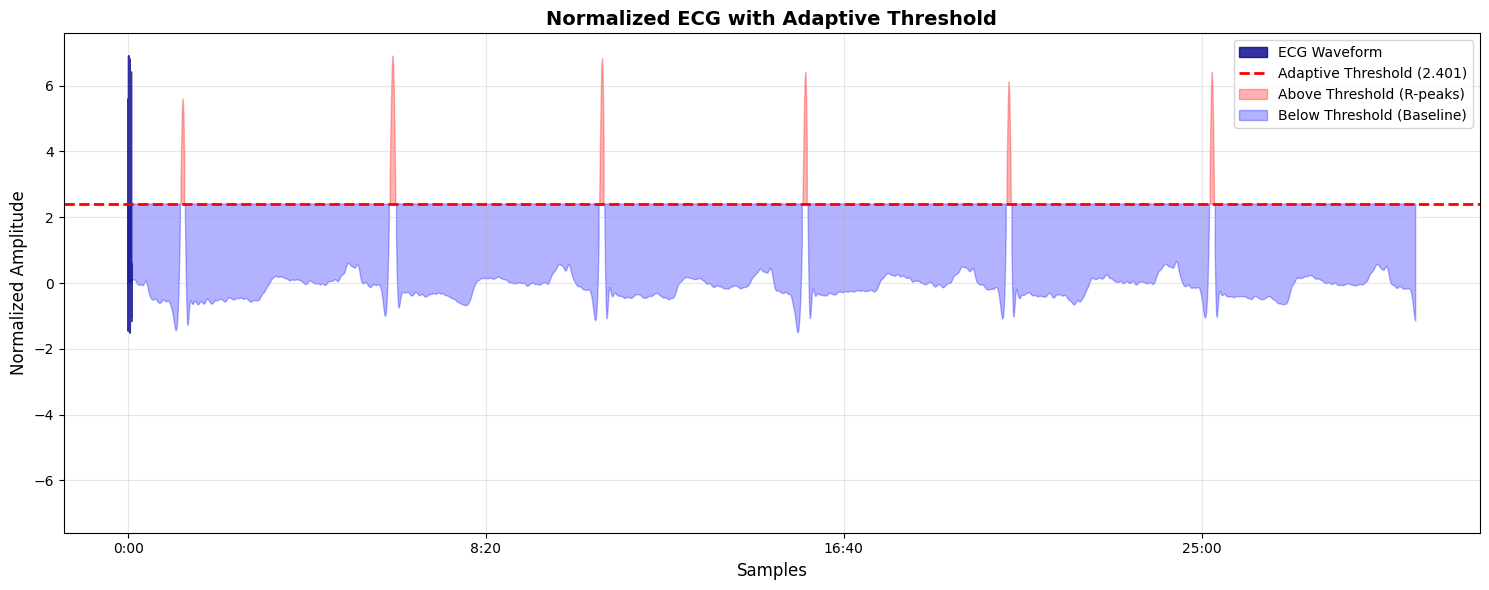

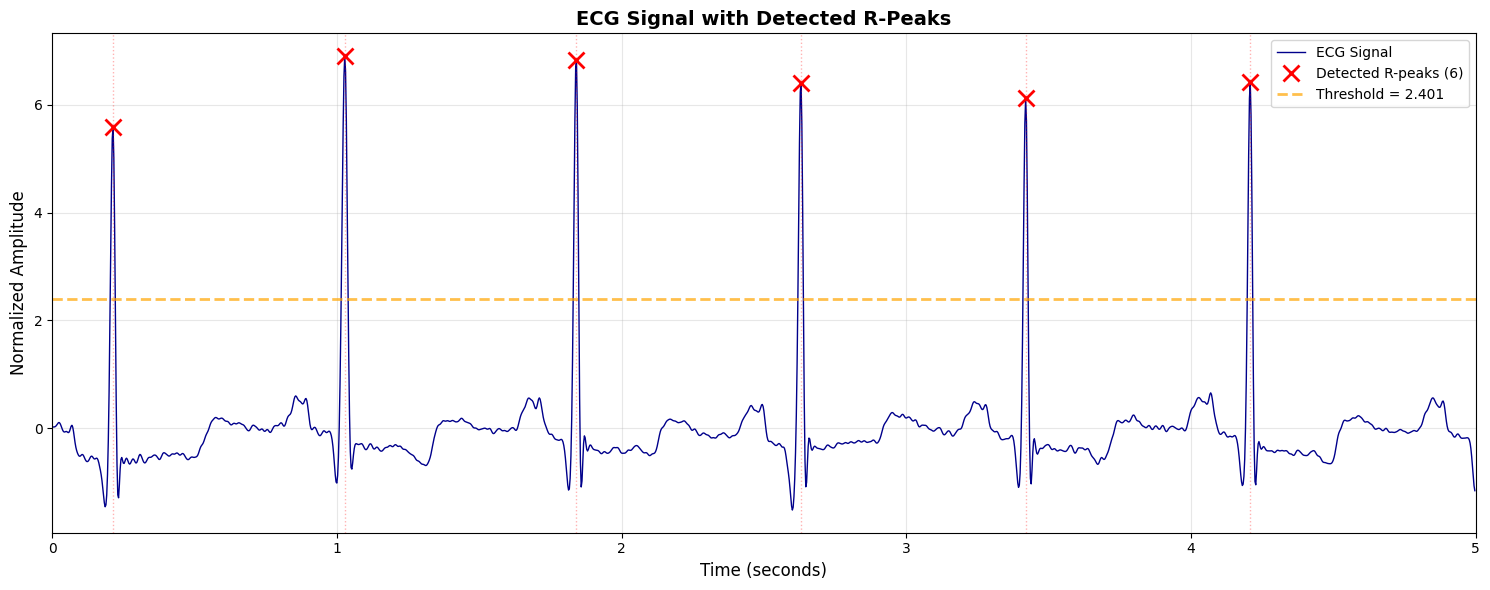

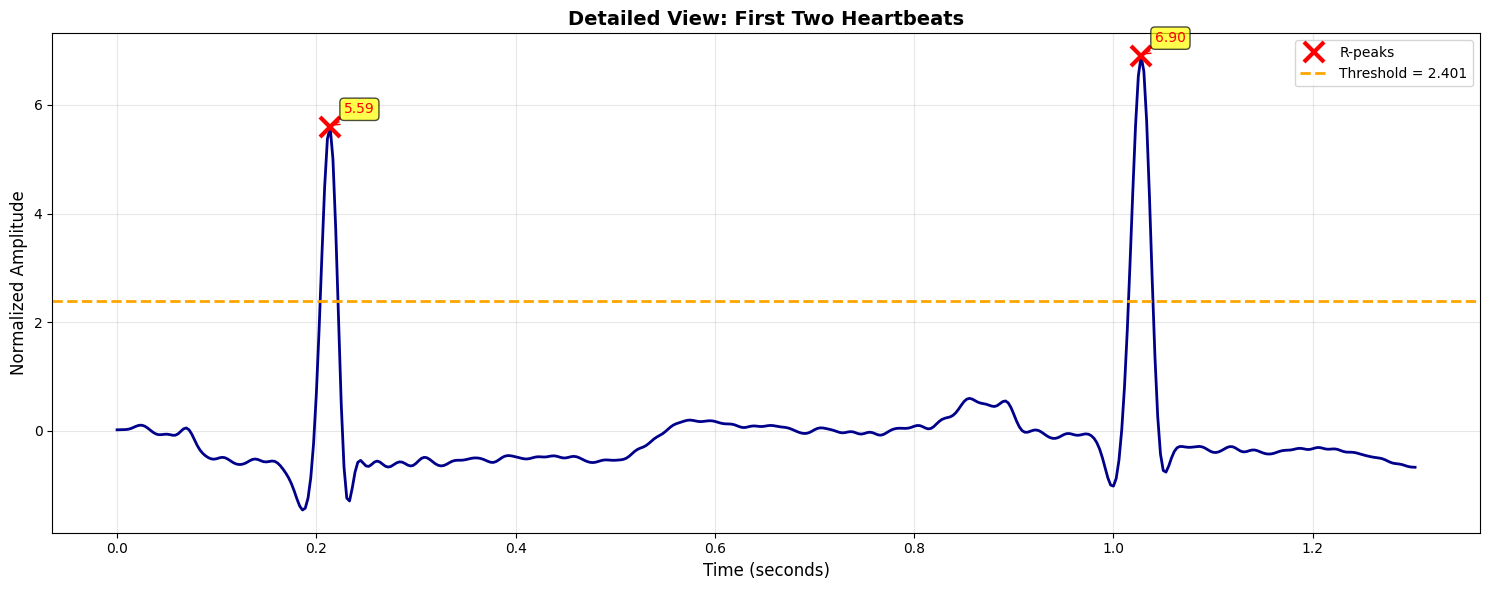


💓 HEART RATE ANALYSIS
  • Number of beats: 6
  • Mean RR interval: 0.799 seconds
  • RR interval range: [0.789, 0.814] seconds
  • Mean heart rate: 75.1 BPM
  • Heart rate range: [73.7, 76.1] BPM
  • Heart rate variability (std): 0.012 seconds


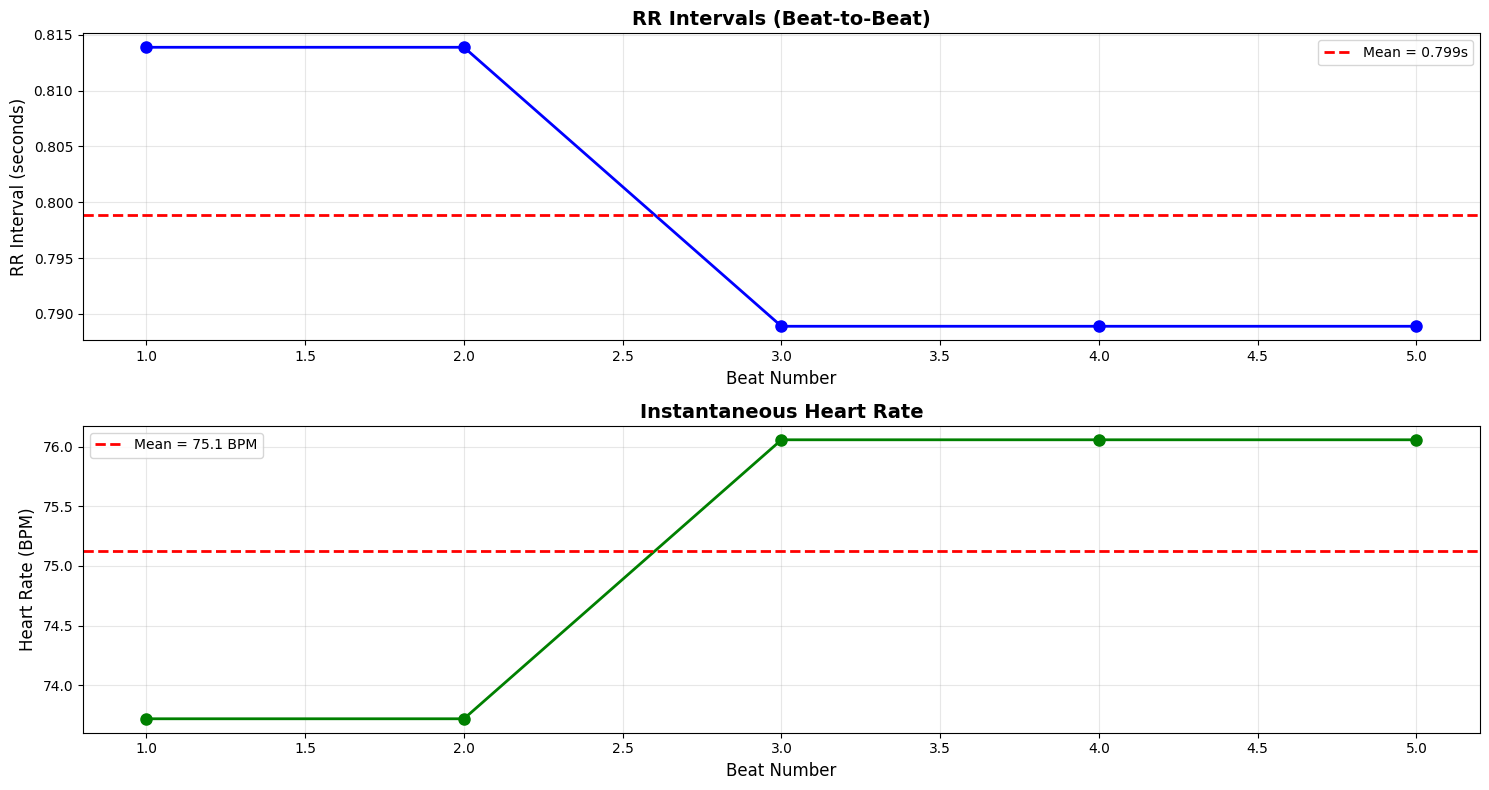


✅ R-PEAK DETECTION COMPLETE!

💾 Variables created:
   • ecg_segment: shape (1800,)
   • peaks: 6 R-peak locations
   • threshold_adaptive: 2.401
   • rr_intervals: shape (5,)
   • heart_rates: shape (5,)

📊 Ready for next step: Beat Segmentation


In [ ]:
import librosa.display
from scipy.signal import find_peaks

# ============================================
# R-PEAK DETECTION WITH ADAPTIVE THRESHOLDING
# ============================================

print('🔍 R-PEAK DETECTION')
print('=' * 50)

# Choose a segment of the ECG signal to analyze (first 5 seconds)
num_seconds = 5
segment_length = int(num_seconds * sampling_frequency)
ecg_segment = ecg_normalized[:segment_length]

print(f'\n📊 Analyzing first {num_seconds} seconds:')
print(f'  • Segment length: {segment_length} samples')
print(f'  • Signal range: [{ecg_segment.min():.3f}, {ecg_segment.max():.3f}]')

# ============================================
# METHOD 1: ADAPTIVE THRESHOLD (BETTER!)
# ============================================

# Calculate adaptive threshold based on signal statistics
signal_mean = np.mean(ecg_segment)
signal_std = np.std(ecg_segment)
signal_max = np.max(ecg_segment)

# Adaptive threshold: mean + percentage of (max - mean)
# This adjusts automatically to signal strength
threshold_adaptive = signal_mean + 0.35 * (signal_max - signal_mean)

print(f'\n📈 Adaptive Thresholding:')
print(f'  • Signal mean: {signal_mean:.3f}')
print(f'  • Signal std: {signal_std:.3f}')
print(f'  • Signal max: {signal_max:.3f}')
print(f'  • Adaptive threshold: {threshold_adaptive:.3f}')

# ============================================
# METHOD 2: ADVANCED PEAK DETECTION
# ============================================

# Use scipy.find_peaks with multiple constraints
peaks, properties = find_peaks(
    ecg_segment,
    height=threshold_adaptive,           # Minimum height (adaptive)
    distance=int(0.6 * sampling_frequency),  # Min 0.6s between peaks (max 100 BPM)
    prominence=0.5,                      # Peak must stand out by 0.5
    width=5                              # Minimum width in samples
)

print(f'\n✓ R-peaks detected: {len(peaks)} beats')
print(f'  • Average heart rate: {(len(peaks) / num_seconds) * 60:.1f} BPM')
print(f'  • Peak locations (samples): {peaks.tolist()}')

# Extract peak properties
peak_heights = properties['peak_heights']
peak_prominences = properties['prominences']

print(f'\n📊 Peak Statistics:')
print(f'  • Mean peak height: {np.mean(peak_heights):.3f}')
print(f'  • Peak height range: [{np.min(peak_heights):.3f}, {np.max(peak_heights):.3f}]')
print(f'  • Mean prominence: {np.mean(peak_prominences):.3f}')

# ============================================
# VISUALIZATION 1: THRESHOLD VIEW
# ============================================

plt.figure(figsize=(15, 6))
librosa.display.waveshow(ecg_segment, sr=sampling_frequency, alpha=0.8, label='ECG Waveform', color='darkblue')

# Draw adaptive threshold line
plt.axhline(y=threshold_adaptive, color='red', linestyle='--', linewidth=2, label=f'Adaptive Threshold ({threshold_adaptive:.3f})')

# Highlight regions above/below threshold
above_threshold = ecg_segment > threshold_adaptive
below_threshold = ecg_segment < threshold_adaptive

plt.fill_between(np.arange(len(ecg_segment)), ecg_segment, threshold_adaptive,
                 where=above_threshold, color='red', alpha=0.3, label='Above Threshold (R-peaks)')
plt.fill_between(np.arange(len(ecg_segment)), ecg_segment, threshold_adaptive,
                 where=below_threshold, color='blue', alpha=0.3, label='Below Threshold (Baseline)')

plt.xlabel('Samples', fontsize=12)
plt.ylabel('Normalized Amplitude', fontsize=12)
plt.title('Normalized ECG with Adaptive Threshold', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 2: DETECTED R-PEAKS
# ============================================

# Create time axis for better readability
time_axis = np.arange(len(ecg_segment)) / sampling_frequency

plt.figure(figsize=(15, 6))

# Plot ECG signal
plt.plot(time_axis, ecg_segment, linewidth=1, color='darkblue', label='ECG Signal')

# Mark detected R-peaks
plt.plot(peaks / sampling_frequency, ecg_segment[peaks], 'rx',
         markersize=12, markeredgewidth=2, label=f'Detected R-peaks ({len(peaks)})')

# Draw threshold line
plt.axhline(y=threshold_adaptive, color='orange', linestyle='--',
            linewidth=2, alpha=0.7, label=f'Threshold = {threshold_adaptive:.3f}')

# Add vertical lines at each R-peak
for peak in peaks:
    plt.axvline(x=peak / sampling_frequency, color='red',
                linestyle=':', alpha=0.3, linewidth=1)

plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Normalized Amplitude', fontsize=12)
plt.title('ECG Signal with Detected R-Peaks', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0, num_seconds])
plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 3: DETAILED VIEW (ZOOMED)
# ============================================

# Show first 2 beats in detail
if len(peaks) >= 2:
    zoom_start = max(0, peaks[0] - 100)
    zoom_end = min(len(ecg_segment), peaks[1] + 100)

    time_zoom = np.arange(zoom_start, zoom_end) / sampling_frequency
    ecg_zoom = ecg_segment[zoom_start:zoom_end]

    plt.figure(figsize=(15, 6))
    plt.plot(time_zoom, ecg_zoom, linewidth=2, color='darkblue')

    # Mark R-peaks in zoomed view
    peaks_in_zoom = peaks[(peaks >= zoom_start) & (peaks < zoom_end)]
    plt.plot(peaks_in_zoom / sampling_frequency, ecg_segment[peaks_in_zoom],
             'rx', markersize=15, markeredgewidth=3, label='R-peaks')

    # Threshold line
    plt.axhline(y=threshold_adaptive, color='orange', linestyle='--',
                linewidth=2, label=f'Threshold = {threshold_adaptive:.3f}')

    # Annotate each peak with its amplitude
    for peak in peaks_in_zoom:
        plt.annotate(f'{ecg_segment[peak]:.2f}',
                    xy=(peak/sampling_frequency, ecg_segment[peak]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=10, color='red',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red'))

    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Normalized Amplitude', fontsize=12)
    plt.title('Detailed View: First Two Heartbeats', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================
# CALCULATE RR INTERVALS
# ============================================

if len(peaks) > 1:
    # Calculate RR intervals (time between consecutive R-peaks)
    rr_intervals = np.diff(peaks) / sampling_frequency  # in seconds
    heart_rates = 60 / rr_intervals  # Convert to BPM

    print('\n💓 HEART RATE ANALYSIS')
    print('=' * 50)
    print(f'  • Number of beats: {len(peaks)}')
    print(f'  • Mean RR interval: {np.mean(rr_intervals):.3f} seconds')
    print(f'  • RR interval range: [{np.min(rr_intervals):.3f}, {np.max(rr_intervals):.3f}] seconds')
    print(f'  • Mean heart rate: {np.mean(heart_rates):.1f} BPM')
    print(f'  • Heart rate range: [{np.min(heart_rates):.1f}, {np.max(heart_rates):.1f}] BPM')
    print(f'  • Heart rate variability (std): {np.std(rr_intervals):.3f} seconds')

    # Plot RR intervals
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))

    # RR intervals over time
    axes[0].plot(range(1, len(rr_intervals)+1), rr_intervals, 'o-',
                color='blue', linewidth=2, markersize=8)
    axes[0].axhline(y=np.mean(rr_intervals), color='red', linestyle='--',
                   linewidth=2, label=f'Mean = {np.mean(rr_intervals):.3f}s')
    axes[0].set_xlabel('Beat Number', fontsize=12)
    axes[0].set_ylabel('RR Interval (seconds)', fontsize=12)
    axes[0].set_title('RR Intervals (Beat-to-Beat)', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Heart rate over time
    axes[1].plot(range(1, len(heart_rates)+1), heart_rates, 'o-',
                color='green', linewidth=2, markersize=8)
    axes[1].axhline(y=np.mean(heart_rates), color='red', linestyle='--',
                   linewidth=2, label=f'Mean = {np.mean(heart_rates):.1f} BPM')
    axes[1].set_xlabel('Beat Number', fontsize=12)
    axes[1].set_ylabel('Heart Rate (BPM)', fontsize=12)
    axes[1].set_title('Instantaneous Heart Rate', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ============================================
# SAVE RESULTS
# ============================================

print('\n✅ R-PEAK DETECTION COMPLETE!')
print('=' * 50)
print('\n💾 Variables created:')
print(f'   • ecg_segment: shape {ecg_segment.shape}')
print(f'   • peaks: {len(peaks)} R-peak locations')
print(f'   • threshold_adaptive: {threshold_adaptive:.3f}')
if len(peaks) > 1:
    print(f'   • rr_intervals: shape {rr_intervals.shape}')
    print(f'   • heart_rates: shape {heart_rates.shape}')

print('\n📊 Ready for next step: Beat Segmentation')

PAN TOMPKINS R PEAKS

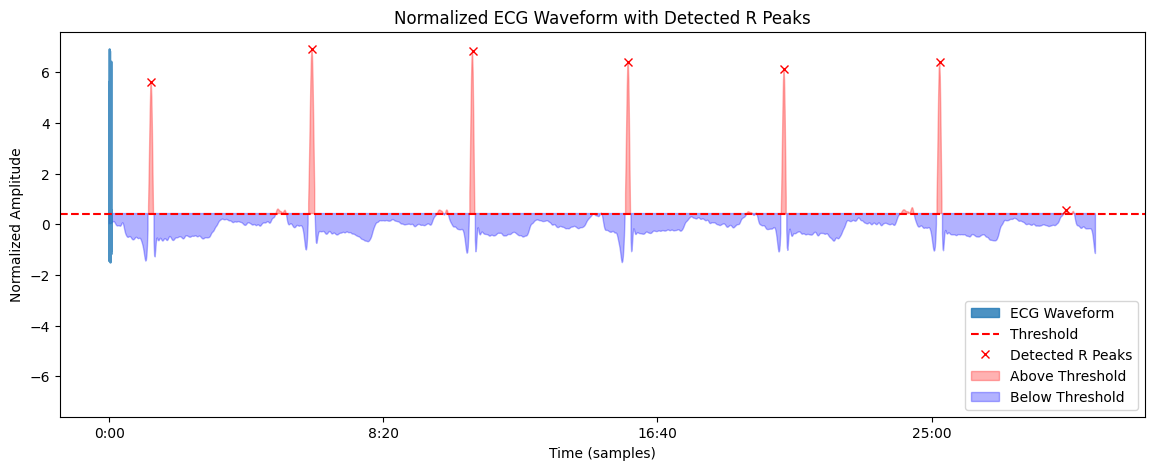

In [ ]:
# Detecting peaks in the thresholded ECG segment for the first 5 seconds
peaks, _ = find_peaks(ecg_segment, height=threshold, distance=sampling_frequency*0.6)

# Plot the thresholded ECG segment with detected R peaks
plt.figure(figsize=(14, 5))
librosa.display.waveshow(ecg_segment, sr=sampling_frequency, alpha=0.8, label='ECG Waveform')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.plot(peaks, ecg_segment[peaks], "x", label='Detected R Peaks', color='red')

above_threshold = ecg_segment > threshold
below_threshold = ecg_segment < threshold

plt.fill_between(np.arange(len(ecg_segment)), ecg_segment, threshold, where=above_threshold, color='red', alpha=0.3, label='Above Threshold')
plt.fill_between(np.arange(len(ecg_segment)), ecg_segment, threshold, where=below_threshold, color='blue', alpha=0.3, label='Below Threshold')

plt.xlabel('Time (samples)')
plt.ylabel('Normalized Amplitude')
plt.title('Normalized ECG Waveform with Detected R Peaks')
plt.legend()
plt.show()


**Advanced Peak Detection**

In [ ]:
!pip install biosppy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install peakutils

🫀 PQRST PEAK DETECTION

✓ Using 7 R-peaks from previous detection

✓ PQRST Detection Complete:
  • P-peaks detected: 7/7
  • Q-peaks detected: 7/7
  • R-peaks: 7/7
  • S-peaks detected: 7/7
  • T-peaks detected: 6/7

✓ Complete beats (all PQRST detected): 6/7

📊 CALCULATING CLINICAL INTERVALS

💓 CARDIAC INTERVALS (with normal ranges):
--------------------------------------------------

  RR Interval:
    • Mean: 0.773s (Normal: 0.6-1.2s)
    • Range: [0.642, 0.814]s
    • Heart Rate: 77.7 BPM (Normal: 60-100 BPM)

  PP Interval:
    • Mean: 0.772s
    • Variability (std): 0.090s

  QRS Duration:
    • Mean: 59.5ms (Normal: 80-120ms)
    • Range: [44.4, 133.3]ms

  PR Interval:
    • Mean: 130.6ms (Normal: 120-200ms)
    • Range: [102.8, 161.1]ms

  QT Interval:
    • Mean: 390.7ms (Normal: 350-450ms)
    • Range: [350.0, 438.9]ms

  QTc (Corrected):
    • Mean: 445.9ms (Normal: <450ms men, <460ms women)


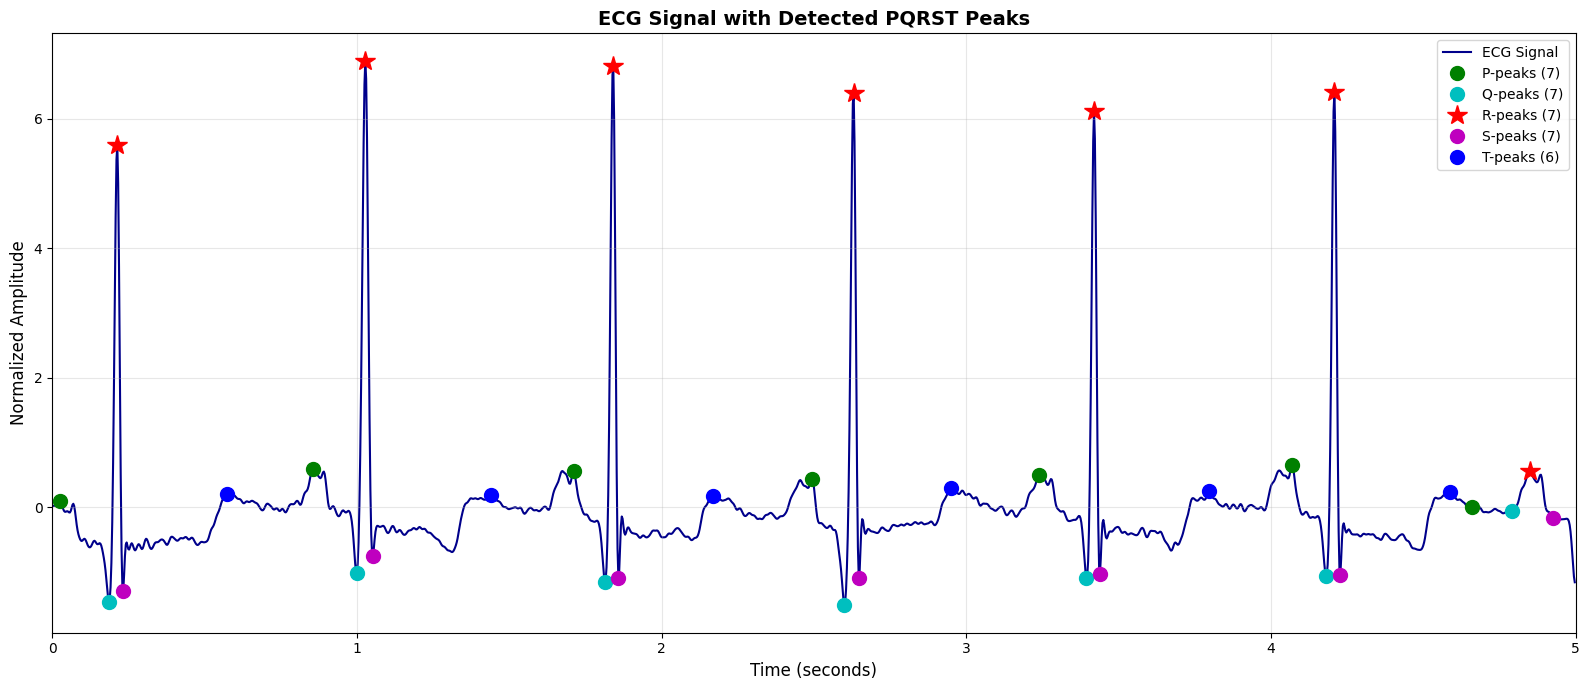

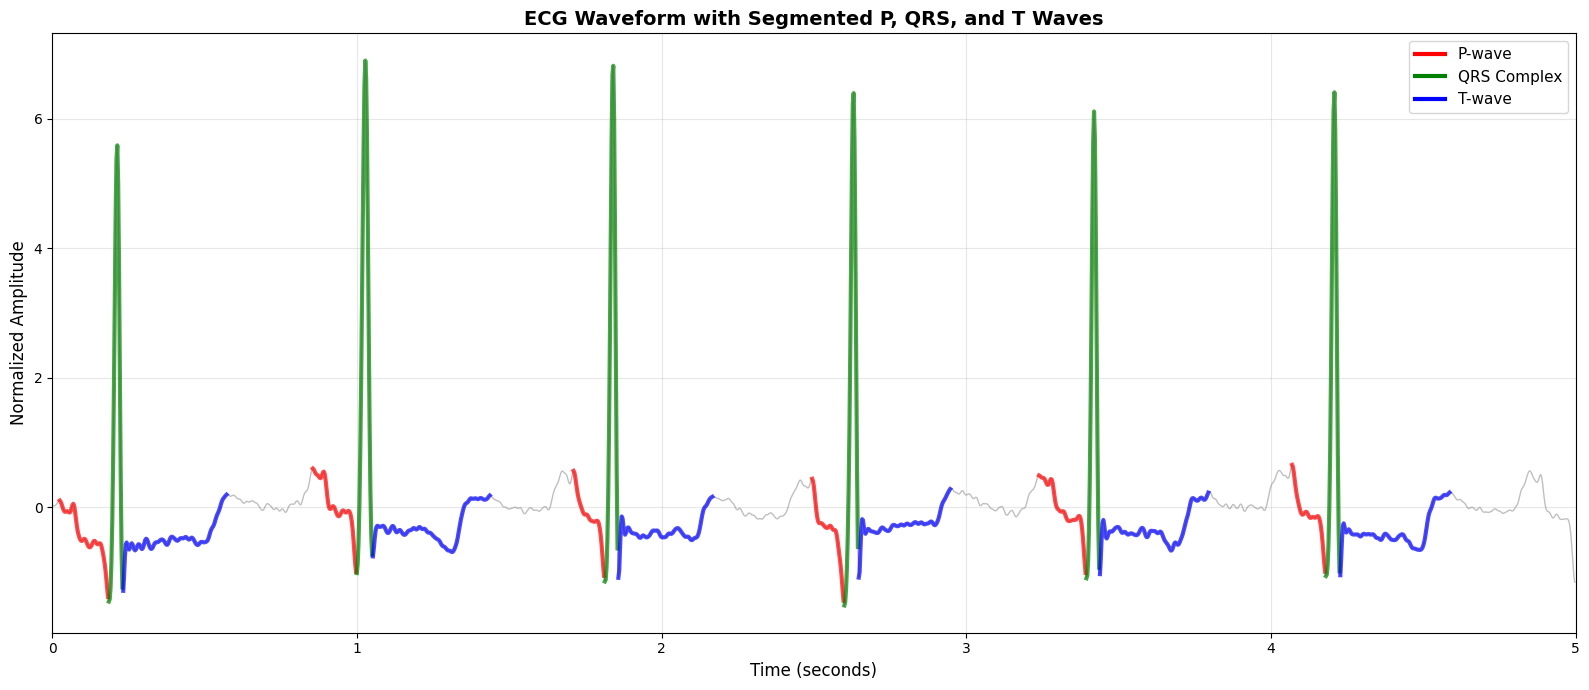

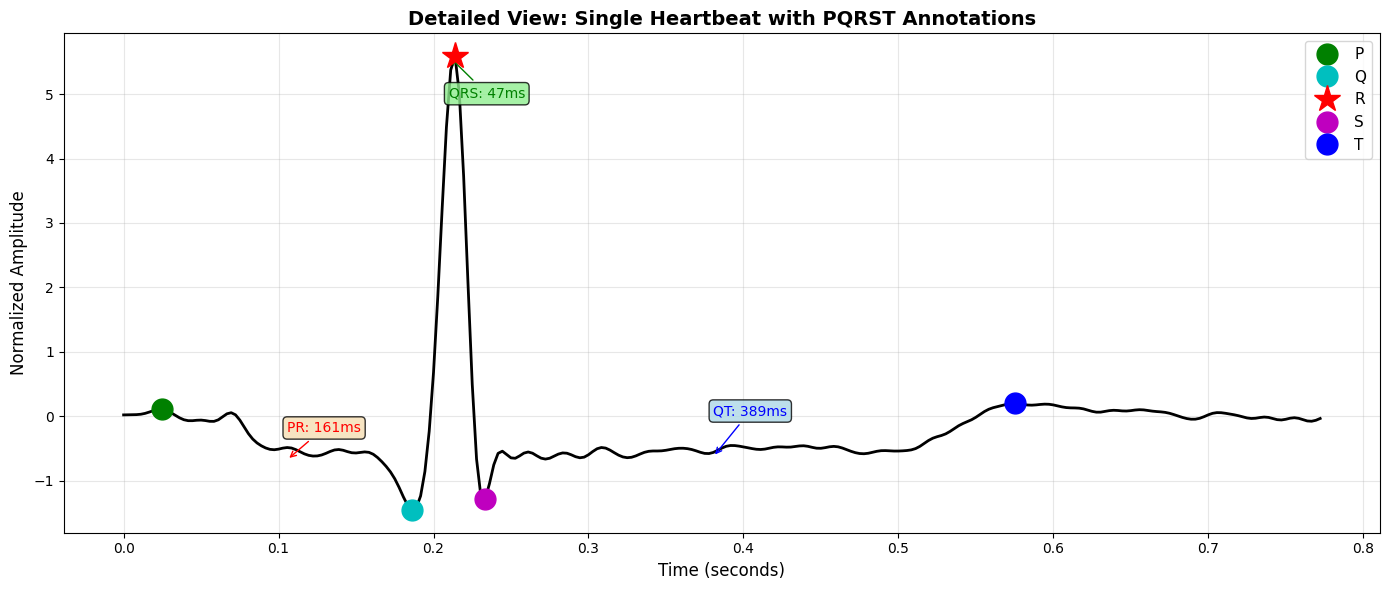


✅ PQRST DETECTION & SEGMENTATION COMPLETE!

💾 Variables created:
   • valid_beats: 7 beats with PQRST data
   • complete_beats: 6 fully detected beats
   • rr_intervals: 6 intervals
   • qrs_durations: 7 durations
   • pr_intervals: 7 intervals
   • qt_intervals: 6 intervals
   • qtc_intervals: 6 corrected intervals

📊 Ready for: Feature Extraction & ML Model Training


In [ ]:
import biosppy
from scipy.signal import find_peaks

# ============================================
# PQRST PEAK DETECTION & WAVE SEGMENTATION
# ============================================

print('🫀 PQRST PEAK DETECTION')
print('=' * 50)

# Use the already detected R-peaks from previous step
rpeaks = peaks  # Using peaks from previous R-peak detection
print(f'\n✓ Using {len(rpeaks)} R-peaks from previous detection')

# ============================================
# IMPROVED PQRST DETECTION FUNCTION
# ============================================

def find_pqrst_peaks_advanced(signal, r_peaks, sampling_rate):
    """
    Advanced PQRST detection with adaptive windows and validation
    """
    p_peaks = []
    q_peaks = []
    s_peaks = []
    t_peaks = []

    # Calculate average RR interval for adaptive windowing
    if len(r_peaks) > 1:
        avg_rr = np.mean(np.diff(r_peaks))
    else:
        avg_rr = int(0.8 * sampling_rate)  # Default 0.8s

    for idx, r_peak in enumerate(r_peaks):
        # === P-WAVE DETECTION ===
        # Search 200ms before R-peak, but not into previous beat
        p_search_start = max(0, r_peak - int(0.20 * sampling_rate))
        if idx > 0:
            # Don't search past 70% into previous RR interval
            prev_beat_limit = r_peaks[idx-1] + int(0.7 * (r_peak - r_peaks[idx-1]))
            p_search_start = max(p_search_start, prev_beat_limit)
        p_search_end = r_peak - int(0.05 * sampling_rate)

        p_window = signal[p_search_start:p_search_end]
        if len(p_window) > 5:  # Minimum window size
            # Find maximum (P-wave is positive deflection)
            p_local = np.argmax(p_window)
            p_peak = p_search_start + p_local

            # Validate: P-peak should be positive
            if signal[p_peak] > 0:
                p_peaks.append(p_peak)
            else:
                p_peaks.append(None)  # Mark as not found
        else:
            p_peaks.append(None)

        # === Q-WAVE DETECTION ===
        q_search_start = r_peak - int(0.06 * sampling_rate)
        q_search_end = r_peak

        q_window = signal[q_search_start:q_search_end]
        if len(q_window) > 3:
            # Find minimum (Q-wave is negative deflection before R)
            q_local = np.argmin(q_window)
            q_peak = q_search_start + q_local

            # Validate: Q should be before R and negative
            if signal[q_peak] < signal[r_peak]:
                q_peaks.append(q_peak)
            else:
                q_peaks.append(None)
        else:
            q_peaks.append(None)

        # === S-WAVE DETECTION ===
        s_search_start = r_peak
        s_search_end = min(len(signal), r_peak + int(0.08 * sampling_rate))

        s_window = signal[s_search_start:s_search_end]
        if len(s_window) > 3:
            # Find minimum (S-wave is negative deflection after R)
            s_local = np.argmin(s_window)
            s_peak = s_search_start + s_local

            # Validate: S should be after R and lower than R
            if s_peak > r_peak and signal[s_peak] < signal[r_peak]:
                s_peaks.append(s_peak)
            else:
                s_peaks.append(None)
        else:
            s_peaks.append(None)

        # === T-WAVE DETECTION ===
        t_search_start = s_peaks[-1] if s_peaks[-1] is not None else r_peak + int(0.05 * sampling_rate)

        # Adaptive T-wave window based on RR interval
        if idx < len(r_peaks) - 1:
            # Search until 60% into next RR interval
            t_search_end = min(len(signal), r_peak + int(0.6 * (r_peaks[idx+1] - r_peak)))
        else:
            t_search_end = min(len(signal), r_peak + int(0.4 * sampling_rate))

        t_window = signal[t_search_start:t_search_end]
        if len(t_window) > 10:
            # Find maximum (T-wave is usually positive)
            t_local = np.argmax(t_window)
            t_peak = t_search_start + t_local

            # Validate: T should be reasonable distance from R
            distance_from_r = (t_peak - r_peak) / sampling_rate
            if 0.15 < distance_from_r < 0.45:  # 150-450ms range
                t_peaks.append(t_peak)
            else:
                t_peaks.append(None)
        else:
            t_peaks.append(None)

    return p_peaks, q_peaks, s_peaks, t_peaks

# Run advanced detection
p_peaks, q_peaks, s_peaks, t_peaks = find_pqrst_peaks_advanced(
    ecg_segment, rpeaks, sampling_frequency
)

print(f'\n✓ PQRST Detection Complete:')
print(f'  • P-peaks detected: {sum(p is not None for p in p_peaks)}/{len(rpeaks)}')
print(f'  • Q-peaks detected: {sum(q is not None for q in q_peaks)}/{len(rpeaks)}')
print(f'  • R-peaks: {len(rpeaks)}/{len(rpeaks)}')
print(f'  • S-peaks detected: {sum(s is not None for s in s_peaks)}/{len(rpeaks)}')
print(f'  • T-peaks detected: {sum(t is not None for t in t_peaks)}/{len(rpeaks)}')

# ============================================
# FILTER VALID PEAKS
# ============================================

valid_beats = []
for i in range(len(rpeaks)):
    beat_data = {
        'index': i,
        'r_peak': rpeaks[i],
        'p_peak': p_peaks[i],
        'q_peak': q_peaks[i],
        's_peak': s_peaks[i],
        't_peak': t_peaks[i],
        'is_complete': all([
            p_peaks[i] is not None,
            q_peaks[i] is not None,
            s_peaks[i] is not None,
            t_peaks[i] is not None
        ])
    }
    valid_beats.append(beat_data)

complete_beats = [b for b in valid_beats if b['is_complete']]
print(f'\n✓ Complete beats (all PQRST detected): {len(complete_beats)}/{len(rpeaks)}')

# ============================================
# CALCULATE CLINICAL INTERVALS
# ============================================

print('\n📊 CALCULATING CLINICAL INTERVALS')
print('=' * 50)

# RR Intervals
rr_intervals = []
for i in range(1, len(rpeaks)):
    rr_intervals.append((rpeaks[i] - rpeaks[i-1]) / sampling_frequency)

# PP Intervals
pp_intervals = []
valid_p_indices = [i for i, p in enumerate(p_peaks) if p is not None]
for i in range(1, len(valid_p_indices)):
    idx1, idx2 = valid_p_indices[i-1], valid_p_indices[i]
    pp_intervals.append((p_peaks[idx2] - p_peaks[idx1]) / sampling_frequency)

# QRS Durations
qrs_durations = []
for beat in valid_beats:
    if beat['q_peak'] is not None and beat['s_peak'] is not None:
        duration = (beat['s_peak'] - beat['q_peak']) / sampling_frequency
        qrs_durations.append(duration * 1000)  # Convert to ms

# PR Intervals
pr_intervals = []
for beat in valid_beats:
    if beat['p_peak'] is not None and beat['q_peak'] is not None:
        pr = (beat['q_peak'] - beat['p_peak']) / sampling_frequency
        pr_intervals.append(pr * 1000)  # Convert to ms

# QT Intervals
qt_intervals = []
for beat in valid_beats:
    if beat['q_peak'] is not None and beat['t_peak'] is not None:
        qt = (beat['t_peak'] - beat['q_peak']) / sampling_frequency
        qt_intervals.append(qt * 1000)  # Convert to ms

# QTc (Corrected QT using Bazett's formula)
qtc_intervals = []
for i, qt in enumerate(qt_intervals):
    if i < len(rr_intervals):
        qtc = qt / np.sqrt(rr_intervals[i])
        qtc_intervals.append(qtc)

# ============================================
# DISPLAY STATISTICS WITH CLINICAL RANGES
# ============================================

print('\n💓 CARDIAC INTERVALS (with normal ranges):')
print('-' * 50)

if rr_intervals:
    print(f'\n  RR Interval:')
    print(f'    • Mean: {np.mean(rr_intervals):.3f}s (Normal: 0.6-1.2s)')
    print(f'    • Range: [{np.min(rr_intervals):.3f}, {np.max(rr_intervals):.3f}]s')
    print(f'    • Heart Rate: {60/np.mean(rr_intervals):.1f} BPM (Normal: 60-100 BPM)')

if pp_intervals:
    print(f'\n  PP Interval:')
    print(f'    • Mean: {np.mean(pp_intervals):.3f}s')
    print(f'    • Variability (std): {np.std(pp_intervals):.3f}s')

if qrs_durations:
    print(f'\n  QRS Duration:')
    print(f'    • Mean: {np.mean(qrs_durations):.1f}ms (Normal: 80-120ms)')
    print(f'    • Range: [{np.min(qrs_durations):.1f}, {np.max(qrs_durations):.1f}]ms')
    if np.mean(qrs_durations) > 120:
        print(f'    ⚠️  WARNING: Prolonged QRS (possible bundle branch block)')

if pr_intervals:
    print(f'\n  PR Interval:')
    print(f'    • Mean: {np.mean(pr_intervals):.1f}ms (Normal: 120-200ms)')
    print(f'    • Range: [{np.min(pr_intervals):.1f}, {np.max(pr_intervals):.1f}]ms')
    if np.mean(pr_intervals) > 200:
        print(f'    ⚠️  WARNING: Prolonged PR (possible AV block)')
    elif np.mean(pr_intervals) < 120:
        print(f'    ⚠️  WARNING: Short PR (possible pre-excitation)')

if qt_intervals:
    print(f'\n  QT Interval:')
    print(f'    • Mean: {np.mean(qt_intervals):.1f}ms (Normal: 350-450ms)')
    print(f'    • Range: [{np.min(qt_intervals):.1f}, {np.max(qt_intervals):.1f}]ms')

if qtc_intervals:
    print(f'\n  QTc (Corrected):')
    print(f'    • Mean: {np.mean(qtc_intervals):.1f}ms (Normal: <450ms men, <460ms women)')
    if np.mean(qtc_intervals) > 450:
        print(f'    ⚠️  WARNING: Prolonged QTc (arrhythmia risk)')

# ============================================
# VISUALIZATION 1: PQRST PEAKS
# ============================================

time_axis = np.arange(len(ecg_segment)) / sampling_frequency

fig, ax = plt.subplots(figsize=(16, 7))

# Plot ECG signal
ax.plot(time_axis, ecg_segment, linewidth=1.5, color='darkblue',
        label='ECG Signal', zorder=1)

# Plot detected peaks
valid_p = [p for p in p_peaks if p is not None]
valid_q = [q for q in q_peaks if q is not None]
valid_s = [s for s in s_peaks if s is not None]
valid_t = [t for t in t_peaks if t is not None]

if valid_p:
    ax.plot(np.array(valid_p)/sampling_frequency, ecg_segment[valid_p],
            'go', markersize=10, label=f'P-peaks ({len(valid_p)})', zorder=3)
if valid_q:
    ax.plot(np.array(valid_q)/sampling_frequency, ecg_segment[valid_q],
            'co', markersize=10, label=f'Q-peaks ({len(valid_q)})', zorder=3)

ax.plot(rpeaks/sampling_frequency, ecg_segment[rpeaks],
        'r*', markersize=15, label=f'R-peaks ({len(rpeaks)})', zorder=4)

if valid_s:
    ax.plot(np.array(valid_s)/sampling_frequency, ecg_segment[valid_s],
            'mo', markersize=10, label=f'S-peaks ({len(valid_s)})', zorder=3)
if valid_t:
    ax.plot(np.array(valid_t)/sampling_frequency, ecg_segment[valid_t],
            'bo', markersize=10, label=f'T-peaks ({len(valid_t)})', zorder=3)

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Normalized Amplitude', fontsize=12)
ax.set_title('ECG Signal with Detected PQRST Peaks', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, num_seconds])
plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 2: WAVE SEGMENTATION
# ============================================

fig, ax = plt.subplots(figsize=(16, 7))

# Plot base ECG
ax.plot(time_axis, ecg_segment, linewidth=1, color='gray',
        alpha=0.5, label='ECG Signal')

# Plot segmented waves for each complete beat
for beat in complete_beats:
    r_peak = beat['r_peak']
    p_peak = beat['p_peak']
    q_peak = beat['q_peak']
    s_peak = beat['s_peak']
    t_peak = beat['t_peak']

    # P-wave segment (from P to Q)
    p_segment = slice(p_peak, q_peak)
    ax.plot(np.arange(p_peak, q_peak)/sampling_frequency,
            ecg_segment[p_segment], 'r-', linewidth=3, alpha=0.7)

    # QRS complex (from Q to S)
    qrs_segment = slice(q_peak, s_peak)
    ax.plot(np.arange(q_peak, s_peak)/sampling_frequency,
            ecg_segment[qrs_segment], 'g-', linewidth=3, alpha=0.7)

    # T-wave segment (from S to T)
    t_segment = slice(s_peak, t_peak)
    ax.plot(np.arange(s_peak, t_peak)/sampling_frequency,
            ecg_segment[t_segment], 'b-', linewidth=3, alpha=0.7)

# Custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='r', linewidth=3, label='P-wave'),
    Line2D([0], [0], color='g', linewidth=3, label='QRS Complex'),
    Line2D([0], [0], color='b', linewidth=3, label='T-wave')
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=11)
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Normalized Amplitude', fontsize=12)
ax.set_title('ECG Waveform with Segmented P, QRS, and T Waves',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, num_seconds])
plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 3: DETAILED BEAT VIEW
# ============================================

if complete_beats:
    # Show first complete beat in detail
    beat = complete_beats[0]

    # Extract beat window (200ms before P to 400ms after T)
    beat_start = max(0, beat['p_peak'] - int(0.1 * sampling_frequency))
    beat_end = min(len(ecg_segment), beat['t_peak'] + int(0.2 * sampling_frequency))

    beat_time = np.arange(beat_start, beat_end) / sampling_frequency
    beat_signal = ecg_segment[beat_start:beat_end]

    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot beat
    ax.plot(beat_time, beat_signal, 'k-', linewidth=2)

    # Mark all peaks
    ax.plot(beat['p_peak']/sampling_frequency, ecg_segment[beat['p_peak']],
            'go', markersize=15, label='P', zorder=5)
    ax.plot(beat['q_peak']/sampling_frequency, ecg_segment[beat['q_peak']],
            'co', markersize=15, label='Q', zorder=5)
    ax.plot(beat['r_peak']/sampling_frequency, ecg_segment[beat['r_peak']],
            'r*', markersize=20, label='R', zorder=5)
    ax.plot(beat['s_peak']/sampling_frequency, ecg_segment[beat['s_peak']],
            'mo', markersize=15, label='S', zorder=5)
    ax.plot(beat['t_peak']/sampling_frequency, ecg_segment[beat['t_peak']],
            'bo', markersize=15, label='T', zorder=5)

    # Add interval annotations
    beat_idx = beat['index']
    if beat_idx < len(pr_intervals):
        ax.annotate(f'PR: {pr_intervals[beat_idx]:.0f}ms',
                   xy=((beat['p_peak'] + beat['q_peak'])/2/sampling_frequency,
                       (ecg_segment[beat['p_peak']] + ecg_segment[beat['q_peak']])/2),
                   xytext=(0, 20), textcoords='offset points',
                   fontsize=10, color='red',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                   arrowprops=dict(arrowstyle='->', color='red'))

    if beat_idx < len(qrs_durations):
        ax.annotate(f'QRS: {qrs_durations[beat_idx]:.0f}ms',
                   xy=((beat['q_peak'] + beat['s_peak'])/2/sampling_frequency,
                       ecg_segment[beat['r_peak']]),
                   xytext=(0, -30), textcoords='offset points',
                   fontsize=10, color='green',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
                   arrowprops=dict(arrowstyle='->', color='green'))

    if beat_idx < len(qt_intervals):
        ax.annotate(f'QT: {qt_intervals[beat_idx]:.0f}ms',
                   xy=((beat['q_peak'] + beat['t_peak'])/2/sampling_frequency,
                       (ecg_segment[beat['q_peak']] + ecg_segment[beat['t_peak']])/2),
                   xytext=(0, 30), textcoords='offset points',
                   fontsize=10, color='blue',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                   arrowprops=dict(arrowstyle='->', color='blue'))

    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Normalized Amplitude', fontsize=12)
    ax.set_title('Detailed View: Single Heartbeat with PQRST Annotations',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================
# SAVE RESULTS
# ============================================

print('\n✅ PQRST DETECTION & SEGMENTATION COMPLETE!')
print('=' * 50)
print('\n💾 Variables created:')
print(f'   • valid_beats: {len(valid_beats)} beats with PQRST data')
print(f'   • complete_beats: {len(complete_beats)} fully detected beats')
print(f'   • rr_intervals: {len(rr_intervals)} intervals')
print(f'   • qrs_durations: {len(qrs_durations)} durations')
print(f'   • pr_intervals: {len(pr_intervals)} intervals')
print(f'   • qt_intervals: {len(qt_intervals)} intervals')
print(f'   • qtc_intervals: {len(qtc_intervals)} corrected intervals')

print('\n📊 Ready for: Feature Extraction & ML Model Training')

**DataSet Explorer**

In [ ]:
"""
MIT-BIH Arrhythmia Database - Complete Dataset Explorer
This script explores all file types and structures in the dataset
"""

import zipfile
import os
from collections import defaultdict
import wfdb
import numpy as np
import pandas as pd

# ============================================================================
# PART 1: EXPLORE ZIP FILE STRUCTURE
# ============================================================================

def explore_zip_structure(zip_path):
    """Explore all files in the MIT-BIH zip"""
    print("="*80)
    print("📦 MIT-BIH DATASET STRUCTURE")
    print("="*80)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        all_files = zip_ref.namelist()

        # Group files by extension
        file_groups = defaultdict(list)
        for file in all_files:
            if not file.endswith('/'):  # Skip directories
                ext = os.path.splitext(file)[1]
                file_groups[ext].append(file)

        # Print summary
        print(f"\n📊 TOTAL FILES: {len(all_files)}")
        print("\n📋 FILE TYPES:")
        for ext, files in sorted(file_groups.items()):
            print(f"  {ext if ext else '[no extension]'}: {len(files)} files")

        # Show sample files for each type
        print("\n📁 SAMPLE FILES BY TYPE:")
        for ext, files in sorted(file_groups.items()):
            print(f"\n  {ext if ext else '[no extension]'}:")
            for file in files[:3]:  # Show first 3
                print(f"    - {os.path.basename(file)}")
            if len(files) > 3:
                print(f"    ... and {len(files)-3} more")

        return file_groups

# ============================================================================
# PART 2: EXTRACT AND READ SAMPLE FILES
# ============================================================================

def extract_sample_files(zip_path, extract_path='./mit_bih_sample'):
    """Extract a few sample files for detailed inspection"""
    print("\n" + "="*80)
    print("📂 EXTRACTING SAMPLE FILES")
    print("="*80)

    os.makedirs(extract_path, exist_ok=True)

    # Extract patient 100 files as example
    sample_patterns = ['100.dat', '100.hea', '100.atr', 'RECORDS', 'ANNOTATORS']

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file in zip_ref.namelist():
            for pattern in sample_patterns:
                if file.endswith(pattern):
                    # Extract to flat directory
                    filename = os.path.basename(file)
                    target_path = os.path.join(extract_path, filename)

                    with zip_ref.open(file) as source, open(target_path, 'wb') as target:
                        target.write(source.read())
                    print(f"  ✓ Extracted: {filename}")

    return extract_path

# ============================================================================
# PART 3: READ AND PARSE EACH FILE TYPE
# ============================================================================

def read_header_file(extract_path, record='100'):
    """Read .hea (header) file - contains metadata"""
    print("\n" + "="*80)
    print("📄 HEADER FILE (.hea) - METADATA")
    print("="*80)

    hea_file = os.path.join(extract_path, f'{record}.hea')

    if os.path.exists(hea_file):
        print(f"\n🔍 Reading {record}.hea:\n")
        with open(hea_file, 'r') as f:
            content = f.read()
            print(content)

        # Parse using wfdb
        record_data = wfdb.rdheader(os.path.join(extract_path, record))

        print("\n📊 PARSED HEADER INFO:")
        print(f"  Record Name: {record_data.record_name}")
        print(f"  Sampling Frequency: {record_data.fs} Hz")
        print(f"  Number of Signals: {record_data.n_sig}")
        print(f"  Signal Names: {record_data.sig_name}")
        print(f"  Total Samples: {record_data.sig_len}")
        print(f"  Duration: {record_data.sig_len / record_data.fs / 60:.2f} minutes")

        return record_data

def read_annotation_file(extract_path, record='100'):
    """Read .atr (annotation) file - contains beat labels"""
    print("\n" + "="*80)
    print("🏷️  ANNOTATION FILE (.atr) - BEAT LABELS")
    print("="*80)

    try:
        # Read annotation file
        annotation = wfdb.rdann(os.path.join(extract_path, record), 'atr')

        print(f"\n📊 ANNOTATION SUMMARY:")
        print(f"  Total Annotations: {len(annotation.sample)}")
        print(f"  Annotation Types: {len(set(annotation.symbol))} unique")

        # Count each beat type
        from collections import Counter
        beat_counts = Counter(annotation.symbol)

        print(f"\n🔢 BEAT TYPE DISTRIBUTION:")
        for beat_type, count in beat_counts.most_common():
            print(f"  '{beat_type}': {count:,} beats")

        # Show first 20 annotations
        print(f"\n📋 FIRST 20 ANNOTATIONS:")
        print(f"  {'Index':<8} {'Sample':<10} {'Time (s)':<12} {'Symbol':<10} {'Description'}")
        print("  " + "-"*70)

        for i in range(min(20, len(annotation.sample))):
            time_sec = annotation.sample[i] / 360  # 360 Hz sampling rate
            print(f"  {i:<8} {annotation.sample[i]:<10} {time_sec:<12.3f} {annotation.symbol[i]:<10} {annotation.aux_note[i] if annotation.aux_note[i] else ''}")

        return annotation

    except Exception as e:
        print(f"  ⚠️  Error reading annotation: {e}")
        return None

def read_signal_file(extract_path, record='100'):
    """Read .dat (signal) file - contains ECG waveform"""
    print("\n" + "="*80)
    print("📈 SIGNAL FILE (.dat) - ECG WAVEFORM DATA")
    print("="*80)

    try:
        # Read signal file
        record_data = wfdb.rdrecord(os.path.join(extract_path, record))

        print(f"\n📊 SIGNAL DATA SUMMARY:")
        print(f"  Shape: {record_data.p_signal.shape}")
        print(f"  Number of Leads: {record_data.n_sig}")
        print(f"  Lead Names: {record_data.sig_name}")
        print(f"  Total Samples: {record_data.sig_len:,}")
        print(f"  Duration: {record_data.sig_len / record_data.fs / 60:.2f} minutes")
        print(f"  Sampling Rate: {record_data.fs} Hz")

        # Show first 10 samples from each lead
        print(f"\n📋 FIRST 10 SAMPLES (Lead MLII):")
        print(f"  {'Sample':<10} {'Value (mV)':<15} {'Time (s)':<12}")
        print("  " + "-"*40)
        for i in range(10):
            time_sec = i / record_data.fs
            print(f"  {i:<10} {record_data.p_signal[i, 0]:<15.3f} {time_sec:<12.6f}")

        return record_data

    except Exception as e:
        print(f"  ⚠️  Error reading signal: {e}")
        return None

def read_records_file(extract_path):
    """Read RECORDS file - lists all available patients"""
    print("\n" + "="*80)
    print("📋 RECORDS FILE - PATIENT LIST")
    print("="*80)

    records_file = os.path.join(extract_path, 'RECORDS')

    if os.path.exists(records_file):
        with open(records_file, 'r') as f:
            records = [line.strip() for line in f if line.strip()]

        print(f"\n📊 TOTAL PATIENTS: {len(records)}")
        print(f"\n🏥 PATIENT IDs:")

        # Show in columns
        for i in range(0, len(records), 10):
            batch = records[i:i+10]
            print(f"  {', '.join(batch)}")

        return records

# ============================================================================
# PART 4: DATA STRUCTURE ANALYSIS
# ============================================================================

def analyze_data_structure(extract_path, record='100'):
    """Comprehensive analysis of data structure"""
    print("\n" + "="*80)
    print("🔬 COMPREHENSIVE DATA STRUCTURE ANALYSIS")
    print("="*80)

    # Load all data
    signal = wfdb.rdrecord(os.path.join(extract_path, record))
    annotation = wfdb.rdann(os.path.join(extract_path, record), 'atr')

    # Calculate key metrics
    total_samples = signal.sig_len
    total_beats = len(annotation.sample)
    labeled_samples = total_beats
    unlabeled_samples = total_samples - labeled_samples

    print(f"\n📊 DATA COMPOSITION:")
    print(f"  Total Signal Samples: {total_samples:,}")
    print(f"  Labeled Samples (Beats): {labeled_samples:,} ({labeled_samples/total_samples*100:.2f}%)")
    print(f"  Unlabeled Samples: {unlabeled_samples:,} ({unlabeled_samples/total_samples*100:.2f}%)")

    # Typical beat window
    print(f"\n🔍 BEAT SEGMENTATION DETAILS:")
    avg_rr_interval = np.mean(np.diff(annotation.sample))
    print(f"  Average R-R Interval: {avg_rr_interval:.0f} samples ({avg_rr_interval/signal.fs:.3f} seconds)")
    print(f"  Average Heart Rate: {60 / (avg_rr_interval/signal.fs):.1f} BPM")
    print(f"  Typical Beat Window: ~{int(avg_rr_interval)} samples (~0.8-1.2 seconds)")

    # Recommended segmentation
    window_size = 360  # 1 second at 360 Hz
    print(f"\n💡 RECOMMENDED SEGMENTATION:")
    print(f"  Window Size: {window_size} samples (1.0 second)")
    print(f"  Before R-peak: {int(window_size*0.3)} samples (0.3 seconds)")
    print(f"  After R-peak: {int(window_size*0.7)} samples (0.7 seconds)")
    print(f"  This captures: P wave + QRS + T wave")

# ============================================================================
# PART 5: BEAT LABEL DESCRIPTIONS
# ============================================================================

def show_beat_labels():
    """Show all possible beat label types"""
    print("\n" + "="*80)
    print("🏷️  MIT-BIH BEAT LABEL DESCRIPTIONS")
    print("="*80)

    labels = {
        'N': 'Normal beat',
        'L': 'Left bundle branch block beat',
        'R': 'Right bundle branch block beat',
        'A': 'Atrial premature beat',
        'a': 'Aberrated atrial premature beat',
        'J': 'Nodal (junctional) premature beat',
        'S': 'Supraventricular premature beat',
        'V': 'Premature ventricular contraction',
        'F': 'Fusion of ventricular and normal beat',
        '[': 'Start of ventricular flutter/fibrillation',
        '!': 'Ventricular flutter wave',
        ']': 'End of ventricular flutter/fibrillation',
        'e': 'Atrial escape beat',
        'j': 'Nodal (junctional) escape beat',
        'E': 'Ventricular escape beat',
        '/': 'Paced beat',
        'f': 'Fusion of paced and normal beat',
        'x': 'Non-conducted P-wave (blocked APB)',
        'Q': 'Unclassifiable beat',
        '|': 'Isolated QRS-like artifact',
    }

    print("\n📋 AAMI Beat Classes (Used for Classification):")
    aami_classes = {
        'N (Normal)': ['N', 'L', 'R', 'e', 'j'],
        'S (Supraventricular)': ['A', 'a', 'J', 'S'],
        'V (Ventricular)': ['V', 'E'],
        'F (Fusion)': ['F'],
        'Q (Unknown)': ['/', 'f', 'Q']
    }

    for aami_class, symbols in aami_classes.items():
        print(f"\n  {aami_class}:")
        for symbol in symbols:
            if symbol in labels:
                print(f"    '{symbol}': {labels[symbol]}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Path to your zip file
    zip_path = "/content/mit-bih-arrhythmia-database-1.0.0.zip"

    # Step 1: Explore zip structure
    file_groups = explore_zip_structure(zip_path)

    # Step 2: Extract sample files
    extract_path = extract_sample_files(zip_path)

    # Step 3: Read and parse each file type
    header = read_header_file(extract_path, '100')
    annotation = read_annotation_file(extract_path, '100')
    signal = read_signal_file(extract_path, '100')
    records = read_records_file(extract_path)

    # Step 4: Analyze data structure
    analyze_data_structure(extract_path, '100')

    # Step 5: Show beat labels
    show_beat_labels()

    print("\n" + "="*80)
    print("✅ DATASET EXPLORATION COMPLETE!")
    print("="*80)
    print("\nNext Steps:")
    print("1. Design CNN+LSTM architecture based on beat segmentation")
    print("2. Create data loader with ~360 sample windows per beat")
    print("3. Implement AAMI classification (5 classes)")
    print("="*80)

📦 MIT-BIH DATASET STRUCTURE

📊 TOTAL FILES: 705

📋 FILE TYPES:
  [no extension]: 10 files
  .1: 1 files
  .2: 1 files
  .3: 1 files
  .4: 1 files
  .5: 1 files
  .at-: 1 files
  .at_: 8 files
  .atr: 72 files
  .bat: 1 files
  .c: 3 files
  .dat: 71 files
  .dvi: 1 files
  .gz: 9 files
  .h: 1 files
  .hea: 71 files
  .htm: 5 files
  .pl: 1 files
  .tr: 6 files
  .txt: 1 files
  .xws: 439 files

📁 SAMPLE FILES BY TYPE:

  [no extension]:
    - ANNOTATORS
    - RECORDS
    - domit
    ... and 7 more

  .1:
    - tab.1

  .2:
    - tab.2

  .3:
    - tab.3

  .4:
    - tab.4

  .5:
    - tab.5

  .at-:
    - 203.at-

  .at_:
    - 108.at_
    - 117.at_
    - 119.at_
    ... and 5 more

  .atr:
    - 100.atr
    - 101.atr
    - 102-0.atr
    ... and 69 more

  .bat:
    - printdir.bat

  .c:
    - dbnotes-html.c
    - dbnotes.c
    - dbtab.c

  .dat:
    - 100.dat
    - 101.dat
    - 102.dat
    ... and 68 more

  .dvi:
    - title.dvi

  .gz:
    - contents.gz
    - cover.gz
    - extext

**Model Architecture**

In [ ]:
"""
COMPLETE CNN-LSTM MODEL FOR MIT-BIH ECG CLASSIFICATION
Continues from preprocessing, R-peak detection, and PQRST segmentation
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# TensorFlow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# ============================================
# STEP 1: LOAD ALL PATIENTS & SEGMENT BEATS
# ============================================

print('\n' + '='*80)
print('📦 LOADING ALL PATIENTS & SEGMENTING BEATS')
print('='*80)

# AAMI class mapping
AAMI_MAPPING = {
    'N': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0,  # Normal
    'A': 1, 'a': 1, 'J': 1, 'S': 1,           # Supraventricular
    'V': 2, 'E': 2,                            # Ventricular
    'F': 3,                                    # Fusion
    '/': 4, 'f': 4, 'Q': 4                    # Unknown
}

CLASS_NAMES = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']

def segment_beats(signal, r_peaks, window_size=360, sampling_rate=360):
    """
    Extract fixed-size windows around each R-peak

    Args:
        signal: ECG signal array
        r_peaks: Array of R-peak indices
        window_size: Number of samples per beat (default 360 = 1 second)
        sampling_rate: Sampling frequency

    Returns:
        beats: Array of shape (n_beats, window_size, n_channels)
    """
    beats = []
    valid_indices = []

    # Window splits: 30% before R-peak, 70% after
    before = int(window_size * 0.3)
    after = window_size - before

    for idx, r_peak in enumerate(r_peaks):
        start = r_peak - before
        end = r_peak + after

        # Check bounds
        if start < 0 or end >= len(signal):
            continue

        # Extract window
        if signal.ndim == 1:
            beat = signal[start:end]
            # Add channel dimension
            beat = beat.reshape(-1, 1)
        else:
            beat = signal[start:end, :]

        # Verify window size
        if len(beat) == window_size:
            beats.append(beat)
            valid_indices.append(idx)

    return np.array(beats), valid_indices


def load_patient_data(patient_id, base_path='/content/mit-bih-arrhythmia-database-1.0.0/'):
    """
    Load and process a single patient's data
    """
    try:
        record_path = f'{base_path}{patient_id}'

        # Load record and annotations
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')

        # Get signal (both leads)
        signal = record.p_signal

        # Preprocess signal
        from scipy.signal import butter, filtfilt

        def bandpass_filter(data, lowcut=0.5, highcut=50.0, fs=360, order=5):
            nyquist = 0.5 * fs
            low = lowcut / nyquist
            high = highcut / nyquist
            b, a = butter(order, [low, high], btype='band')
            if data.ndim == 1:
                return filtfilt(b, a, data)
            else:
                filtered = np.zeros_like(data)
                for i in range(data.shape[1]):
                    filtered[:, i] = filtfilt(b, a, data[:, i])
                return filtered

        # Filter signal
        signal_filtered = bandpass_filter(signal, fs=record.fs)

        # Normalize per-lead
        signal_normalized = np.zeros_like(signal_filtered)
        for i in range(signal_filtered.shape[1]):
            mean = np.mean(signal_filtered[:, i])
            std = np.std(signal_filtered[:, i])
            signal_normalized[:, i] = (signal_filtered[:, i] - mean) / (std + 1e-8)

        # Get R-peaks and labels
        r_peaks = annotation.sample
        beat_labels = annotation.symbol

        # Segment beats
        beats, valid_indices = segment_beats(signal_normalized, r_peaks,
                                            window_size=360,
                                            sampling_rate=record.fs)

        # Get corresponding labels
        valid_labels = [beat_labels[i] for i in valid_indices]

        # Map to AAMI classes
        aami_labels = []
        filtered_beats = []
        for beat, label in zip(beats, valid_labels):
            if label in AAMI_MAPPING:
                aami_labels.append(AAMI_MAPPING[label])
                filtered_beats.append(beat)

        return np.array(filtered_beats), np.array(aami_labels), patient_id

    except Exception as e:
        print(f"  ⚠️  Error loading patient {patient_id}: {e}")
        return None, None, patient_id


# Load all patients
records_file = '/content/mit-bih-arrhythmia-database-1.0.0/RECORDS'
with open(records_file, 'r') as f:
    all_patient_ids = [line.strip() for line in f if line.strip()]

print(f'\n📋 Found {len(all_patient_ids)} patients to process')
print(f'Patient IDs: {all_patient_ids}\n')

all_beats = []
all_labels = []
patient_beat_counts = {}

for patient_id in all_patient_ids:
    print(f'Processing {patient_id}...', end=' ')
    beats, labels, pid = load_patient_data(patient_id)

    if beats is not None and len(beats) > 0:
        all_beats.append(beats)
        all_labels.append(labels)
        patient_beat_counts[pid] = len(beats)
        print(f'✓ {len(beats)} beats')
    else:
        print('✗ Failed')

# Concatenate all data
X_data = np.concatenate(all_beats, axis=0)
y_data = np.concatenate(all_labels, axis=0)

print(f'\n✅ DATA LOADING COMPLETE!')
print(f'  • Total beats: {len(X_data):,}')
print(f'  • Beat shape: {X_data.shape}')
print(f'  • Label shape: {y_data.shape}')

# Class distribution
class_counts = Counter(y_data)
print(f'\n📊 Class Distribution:')
for class_idx in sorted(class_counts.keys()):
    count = class_counts[class_idx]
    percentage = (count / len(y_data)) * 100
    print(f'  • {CLASS_NAMES[class_idx]}: {count:,} ({percentage:.2f}%)')

# ============================================
# STEP 2: HANDCRAFTED FEATURE EXTRACTION
# ============================================

print('\n' + '='*80)
print('🔧 EXTRACTING HANDCRAFTED FEATURES')
print('='*80)

def extract_morphological_features(beat):
    """Extract time-domain morphological features from a beat"""
    features = []

    # Use first lead (MLII)
    signal = beat[:, 0] if beat.ndim > 1 else beat

    # 1. Statistical features
    features.append(np.mean(signal))
    features.append(np.std(signal))
    features.append(np.max(signal))
    features.append(np.min(signal))
    features.append(np.max(signal) - np.min(signal))  # Peak-to-peak

    # 2. Peak detection features
    r_peak_idx = np.argmax(signal)
    features.append(signal[r_peak_idx])  # R-peak amplitude

    # 3. Slope features
    diff_signal = np.diff(signal)
    features.append(np.max(diff_signal))  # Max upslope
    features.append(np.min(diff_signal))  # Max downslope

    # 4. Energy
    features.append(np.sum(signal ** 2))

    # 5. Zero crossings
    zero_crossings = np.sum(np.diff(np.sign(signal)) != 0)
    features.append(zero_crossings)

    return features

def extract_frequency_features(beat, n_coeffs=10):
    """Extract frequency-domain features using FFT"""
    signal = beat[:, 0] if beat.ndim > 1 else beat

    # FFT
    fft_vals = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_vals)

    # Take first n_coeffs (excluding DC component)
    features = fft_magnitude[1:n_coeffs+1].tolist()

    return features

def extract_all_features(beats):
    """Extract all handcrafted features for all beats"""
    all_features = []

    print(f'Extracting features from {len(beats)} beats...')
    for i, beat in enumerate(beats):
        if (i + 1) % 10000 == 0:
            print(f'  Processed {i+1}/{len(beats)} beats')

        morph_features = extract_morphological_features(beat)
        freq_features = extract_frequency_features(beat, n_coeffs=10)

        combined_features = morph_features + freq_features
        all_features.append(combined_features)

    return np.array(all_features)

# Extract features
X_features = extract_all_features(X_data)

print(f'\n✓ Feature extraction complete!')
print(f'  • Feature shape: {X_features.shape}')
print(f'  • Features per beat: {X_features.shape[1]}')

# Normalize features
feature_scaler = StandardScaler()
X_features_normalized = feature_scaler.fit_transform(X_features)

print(f'  • Features normalized')

# ============================================
# STEP 3: TRAIN-VALIDATION-TEST SPLIT
# ============================================

print('\n' + '='*80)
print('🔀 SPLITTING DATA (Inter-Patient Split)')
print('='*80)

# Patient-level split
patient_ids = list(patient_beat_counts.keys())
train_patients, temp_patients = train_test_split(patient_ids, test_size=0.3, random_state=42)
val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

print(f'\n📊 Patient Split:')
print(f'  • Training: {len(train_patients)} patients - {train_patients}')
print(f'  • Validation: {len(val_patients)} patients - {val_patients}')
print(f'  • Test: {len(test_patients)} patients - {test_patients}')

# Create patient-to-beat mapping
patient_indices = {}
start_idx = 0
for patient_id in all_patient_ids:
    if patient_id in patient_beat_counts:
        count = patient_beat_counts[patient_id]
        patient_indices[patient_id] = list(range(start_idx, start_idx + count))
        start_idx += count

# Get indices for each split
train_indices = []
val_indices = []
test_indices = []

for patient_id in train_patients:
    train_indices.extend(patient_indices[patient_id])
for patient_id in val_patients:
    val_indices.extend(patient_indices[patient_id])
for patient_id in test_patients:
    test_indices.extend(patient_indices[patient_id])

# Split data
X_train = X_data[train_indices]
X_val = X_data[val_indices]
X_test = X_data[test_indices]

X_train_features = X_features_normalized[train_indices]
X_val_features = X_features_normalized[val_indices]
X_test_features = X_features_normalized[test_indices]

y_train = y_data[train_indices]
y_val = y_data[val_indices]
y_test = y_data[test_indices]

print(f'\n📊 Data Split Summary:')
print(f'  • Training: {len(X_train):,} beats')
print(f'  • Validation: {len(X_val):,} beats')
print(f'  • Test: {len(X_test):,} beats')

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=5)
y_val_cat = to_categorical(y_val, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

# ============================================
# STEP 4: CALCULATE CLASS WEIGHTS
# ============================================

print('\n' + '='*80)
print('⚖️  CALCULATING CLASS WEIGHTS')
print('='*80)

# Calculate class weights for imbalanced data
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print(f'\n📊 Class Weights:')
for class_idx, weight in class_weights.items():
    print(f'  • {CLASS_NAMES[class_idx]}: {weight:.3f}')

# ============================================
# STEP 5: BUILD CNN-LSTM MODEL
# ============================================

print('\n' + '='*80)
print('🏗️  BUILDING CNN-LSTM MODEL')
print('='*80)

def create_attention_layer():
    """Custom attention layer"""
    def attention(x):
        # x shape: (batch, time_steps, features)
        attention_weights = layers.Dense(1, activation='tanh')(x)
        attention_weights = layers.Flatten()(attention_weights)
        attention_weights = layers.Activation('softmax')(attention_weights)
        attention_weights = layers.RepeatVector(x.shape[-1])(attention_weights)
        attention_weights = layers.Permute([2, 1])(attention_weights)

        # Weighted sum
        output = layers.Multiply()([x, attention_weights])
        output = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(output)
        return output

    return attention

def build_cnn_lstm_model(input_shape=(360, 2), num_features=20, num_classes=5):
    """
    Build CNN-LSTM model with attention and feature fusion
    """
    # ========================================
    # Branch 1: CNN-LSTM for raw signal
    # ========================================
    signal_input = Input(shape=input_shape, name='signal_input')

    # CNN Block 1
    x = layers.Conv1D(32, kernel_size=7, padding='same')(signal_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    # CNN Block 2
    x = layers.Conv1D(64, kernel_size=5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    # CNN Block 3
    x = layers.Conv1D(128, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True,
                                        dropout=0.3, recurrent_dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True,
                                        dropout=0.3, recurrent_dropout=0.3))(x)

    # Attention mechanism
    attention_weights = layers.Dense(128, activation='tanh')(x)
    attention_weights = layers.Dense(1)(attention_weights)
    attention_weights = layers.Flatten()(attention_weights)
    attention_weights = layers.Activation('softmax')(attention_weights)
    attention_weights = layers.RepeatVector(256)(attention_weights)
    attention_weights = layers.Permute([2, 1])(attention_weights)

    # Apply attention
    x_attended = layers.Multiply()([x, attention_weights])
    class AttentionSum(layers.Layer):
        """Custom layer to sum along time axis"""
        def call(self, inputs):
            return tf.reduce_sum(inputs, axis=1)

        def compute_output_shape(self, input_shape):
            return (input_shape[0], input_shape[2])

    lstm_output = AttentionSum(name='attention_sum')(x_attended)

    # ========================================
    # Branch 2: Dense network for features
    # ========================================
    features_input = Input(shape=(num_features,), name='features_input')

    f = layers.Dense(128, activation='relu')(features_input)
    f = layers.BatchNormalization()(f)
    f = layers.Dropout(0.3)(f)

    f = layers.Dense(64, activation='relu')(f)
    f = layers.BatchNormalization()(f)
    f = layers.Dropout(0.3)(f)

    # ========================================
    # Fusion and Classification
    # ========================================
    merged = layers.Concatenate()([lstm_output, f])

    # Classification head
    z = layers.Dense(256, activation='relu')(merged)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.5)(z)

    z = layers.Dense(128, activation='relu')(z)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.5)(z)

    output = layers.Dense(num_classes, activation='softmax', name='output')(z)

    # Build model
    model = Model(inputs=[signal_input, features_input], outputs=output)

    return model

# Create model
model = build_cnn_lstm_model(
    input_shape=(360, 2),
    num_features=X_train_features.shape[1],
    num_classes=5
)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# Print model summary
model.summary()

print(f'\n✓ Model built successfully!')
print(f'  • Total parameters: {model.count_params():,}')

# ============================================
# STEP 6: SETUP TRAINING CALLBACKS
# ============================================

print('\n' + '='*80)
print('⚙️  SETTING UP TRAINING CALLBACKS')
print('='*80)

# Create callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_lstm_ecg.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

print('✓ Callbacks configured:')
print('  • Early stopping (patience=15)')
print('  • Model checkpoint (best validation accuracy)')
print('  • Reduce LR on plateau (factor=0.5, patience=5)')

# ============================================
# STEP 7: TRAIN MODEL
# ============================================

print('\n' + '='*80)
print('🚀 TRAINING MODEL')
print('='*80)

# Training parameters
BATCH_SIZE = 128
EPOCHS = 100

print(f'\n📊 Training Configuration:')
print(f'  • Batch size: {BATCH_SIZE}')
print(f'  • Max epochs: {EPOCHS}')
print(f'  • Training samples: {len(X_train):,}')
print(f'  • Validation samples: {len(X_val):,}')
print(f'  • Steps per epoch: {len(X_train) // BATCH_SIZE}')

# Train model
history = model.fit(
    [X_train, X_train_features],
    y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_val, X_val_features], y_val_cat),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print('\n✅ Training complete!')

# ============================================
# STEP 8: EVALUATE MODEL
# ============================================

print('\n' + '='*80)
print('📊 MODEL EVALUATION')
print('='*80)

# Load best model
model = keras.models.load_model('best_cnn_lstm_ecg.h5')

# Evaluate on test set
test_loss, test_accuracy, test_auc = model.evaluate(
    [X_test, X_test_features],
    y_test_cat,
    batch_size=BATCH_SIZE,
    verbose=0
)

print(f'\n🎯 Test Set Performance:')
print(f'  • Loss: {test_loss:.4f}')
print(f'  • Accuracy: {test_accuracy*100:.2f}%')
print(f'  • AUC: {test_auc:.4f}')

# Get predictions
y_pred_prob = model.predict([X_test, X_test_features], batch_size=BATCH_SIZE)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
print(f'\n📋 Classification Report:')
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f'\n🔢 Confusion Matrix:')
print(cm)

# Per-class metrics
print(f'\n📊 Per-Class Performance:')
for i, class_name in enumerate(CLASS_NAMES):
    mask = (y_test == i)
    if mask.sum() > 0:
        class_accuracy = (y_pred[mask] == y_test[mask]).mean()
        print(f'  • {class_name}: {class_accuracy*100:.2f}% ({mask.sum()} samples)')

# ============================================
# STEP 9: VISUALIZATION
# ============================================

print('\n' + '='*80)
print('📈 GENERATING VISUALIZATIONS')
print('='*80)

# Plot 1: Training History
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC', linewidth=2)
axes[2].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('AUC', fontsize=12)
axes[2].set_title('Training & Validation AUC', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot 3: Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            vmin=0, vmax=1, cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Normalized Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot 4: ROC Curves (One-vs-Rest)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, class_name in enumerate(CLASS_NAMES):
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
    roc_auc = roc_auc_score(y_test_cat[:, i], y_pred_prob[:, i])

    axes[i].plot(fpr, tpr, linewidth=2,
                label=f'AUC = {roc_auc:.3f}')
    axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
    axes[i].set_xlabel('False Positive Rate', fontsize=10)
    axes[i].set_ylabel('True Positive Rate', fontsize=10)
    axes[i].set_title(f'ROC Curve: {class_name}', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

# Hide extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Plot 5: Class Distribution Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training set
train_counts = Counter(y_train)
axes[0].bar([CLASS_NAMES[i] for i in sorted(train_counts.keys())],
           [train_counts[i] for i in sorted(train_counts.keys())],
           color='skyblue')
axes[0].set_title('Training Set Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# Validation set
val_counts = Counter(y_val)
axes[1].bar([CLASS_NAMES[i] for i in sorted(val_counts.keys())],
           [val_counts[i] for i in sorted(val_counts.keys())],
           color='lightgreen')
axes[1].set_title('Validation Set Distribution', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)

# Test set
test_counts = Counter(y_test)
axes[2].bar([CLASS_NAMES[i] for i in sorted(test_counts.keys())],
           [test_counts[i] for i in sorted(test_counts.keys())],
           color='salmon')
axes[2].set_title('Test Set Distribution', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=10)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ============================================
# STEP 10: SAVE RESULTS
# ============================================

print('\n' + '='*80)
print('💾 SAVING RESULTS')
print('='*80)

# Save model architecture as JSON
model_json = model.to_json()
with open('cnn_lstm_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print('✓ Model architecture saved')

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
print('✓ Training history saved')

# Save evaluation metrics
metrics = {
    'test_loss': test_loss,
    'test_accuracy': test_accuracy,
    'test_auc': test_auc
}
pd.DataFrame([metrics]).to_csv('test_metrics.csv', index=False)
print('✓ Test metrics saved')

# Save predictions
predictions_df = pd.DataFrame({
    'true_label': y_test,
    'predicted_label': y_pred,
    'true_class': [CLASS_NAMES[i] for i in y_test],
    'predicted_class': [CLASS_NAMES[i] for i in y_pred]
})
for i, class_name in enumerate(CLASS_NAMES):
    predictions_df[f'prob_{class_name}'] = y_pred_prob[:, i]

predictions_df.to_csv('test_predictions.csv', index=False)
print('✓ Predictions saved')

print('\n' + '='*80)
print('✅ COMPLETE PIPELINE FINISHED!')
print('='*80)
print('\n📁 Output Files:')
print('  • best_cnn_lstm_ecg.h5 - Best model weights')
print('  • cnn_lstm_architecture.json - Model architecture')
print('  • training_history.csv - Training metrics per epoch')
print('  • test_metrics.csv - Final test set metrics')
print('  • test_predictions.csv - Detailed predictions on test set')

print('\n🎯 Final Results:')
print(f'  • Test Accuracy: {test_accuracy*100:.2f}%')
print(f'  • Test AUC: {test_auc:.4f}')
print(f'  • Model Parameters: {model.count_params():,}')
print(f'  • Training Epochs: {len(history.history["loss"])}')

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

📦 LOADING ALL PATIENTS & SEGMENTING BEATS

📋 Found 48 patients to process
Patient IDs: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']

Processing 100... ✓ 2271 beats
Processing 101... ✓ 1863 beats
Processing 102... ✓ 2186 beats
Processing 103... ✓ 2083 beats
Processing 104... ✓ 2227 beats
Processing 105... ✓ 2572 beats
Processing 106... ✓ 2026 beats
Processing 107... ✓ 2135 beats
Processing 108... ✓ 1761 beats
Processing 109... ✓ 2531 beats
Processing 111... ✓ 2124 beats
Processing 112... ✓ 2538 beats
Processing 113... ✓ 1794 beats
Processing 114... ✓ 1878 beats
Processing 115... ✓ 1952 beats


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal_input        │ (None, 360, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 360, 32)   │        480 │ signal_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 360, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 360, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 180, 32)   │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 180, 32)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 180, 64)   │     10,304 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 180, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 180, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 90, 64)    │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 90, 64)    │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 90, 128)   │     24,704 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 90, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 45, 128)   │          0 │ activation_2[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 45, 128)   │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 45, 256)   │    263,168 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 45, 256)   │    394,240 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 45, 128)   │     32,896 │ bidirectional_1[

 Total params: 855,782 (3.26 MB)

 Trainable params: 854,182 (3.26 MB)

 Non-trainable params: 1,600 (6.25 KB)


✓ Model built successfully!
  • Total parameters: 855,782

⚙️  SETTING UP TRAINING CALLBACKS
✓ Callbacks configured:
  • Early stopping (patience=15)
  • Model checkpoint (best validation accuracy)
  • Reduce LR on plateau (factor=0.5, patience=5)

🚀 TRAINING MODEL

📊 Training Configuration:
  • Batch size: 128
  • Max epochs: 100
  • Training samples: 75,387
  • Validation samples: 14,907
  • Steps per epoch: 588
Epoch 1/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.4872 - auc: 0.7617 - loss: 1.1355
Epoch 1: val_accuracy improved from -inf to 0.85135, saving model to best_cnn_lstm_ecg.h5


589/589 ━━━━━━━━━━━━━━━━━━━━ 344s 542ms/step - accuracy: 0.4875 - auc: 0.7619 - loss: 1.1349 - val_accuracy: 0.8513 - val_auc: 0.9625 - val_loss: 0.5232 - learning_rate: 0.0010
Epoch 2/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.8610 - auc: 0.9670 - loss: 0.4087
Epoch 2: val_accuracy did not improve from 0.85135
589/589 ━━━━━━━━━━━━━━━━━━━━ 374s 540ms/step - accuracy: 0.8610 - auc: 0.9670 - loss: 0.4087 - val_accuracy: 0.8317 - val_auc: 0.9536 - val_loss: 0.5890 - learning_rate: 0.0010
Epoch 3/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9091 - auc: 0.9818 - loss: 0.2992
Epoch 3: val_accuracy did not improve from 0.85135
589/589 ━━━━━━━━━━━━━━━━━━━━ 318s 540ms/step - accuracy: 0.9091 - auc: 0.9818 - loss: 0.2992 - val_accuracy: 0.7458 - val_auc: 0.8913 - val_loss: 1.0501 - learning_rate: 0.0010
Epoch 4/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9222 - auc: 0.9853 - loss: 0.2907
Epoch 4: val_accuracy improved from 0.85135 to 0.87523, sa

589/589 ━━━━━━━━━━━━━━━━━━━━ 318s 539ms/step - accuracy: 0.9222 - auc: 0.9853 - loss: 0.2907 - val_accuracy: 0.8752 - val_auc: 0.9686 - val_loss: 0.4772 - learning_rate: 0.0010
Epoch 5/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9319 - auc: 0.9886 - loss: 0.2505
Epoch 5: val_accuracy did not improve from 0.87523
589/589 ━━━━━━━━━━━━━━━━━━━━ 319s 540ms/step - accuracy: 0.9319 - auc: 0.9886 - loss: 0.2505 - val_accuracy: 0.8340 - val_auc: 0.9564 - val_loss: 0.5755 - learning_rate: 0.0010
Epoch 6/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9345 - auc: 0.9902 - loss: 0.2412
Epoch 6: val_accuracy did not improve from 0.87523
589/589 ━━━━━━━━━━━━━━━━━━━━ 317s 539ms/step - accuracy: 0.9345 - auc: 0.9902 - loss: 0.2412 - val_accuracy: 0.8678 - val_auc: 0.9641 - val_loss: 0.5257 - learning_rate: 0.0010
Epoch 7/100
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9382 - auc: 0.9907 - loss: 0.1889
Epoch 7: val_accuracy did not improve from 0.87523
589/589

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 45, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_97>',)
  • kwargs={'mask': 'None'}

**Extensive Visualization**

In [ ]:
"""
EXTENSIVE BEAT-LEVEL VISUALIZATION
Shows actual vs predicted labels for each beat in test set
Includes waveform visualization, confidence analysis, and error analysis
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

print('='*80)
print('🎨 EXTENSIVE BEAT-LEVEL VISUALIZATION')
print('='*80)

# ============================================
# PART 1: CREATE COMPREHENSIVE PREDICTIONS DATAFRAME
# ============================================

print('\n📊 Creating comprehensive predictions dataframe...')

# Create detailed predictions dataframe
results_df = pd.DataFrame({
    'beat_index': range(len(y_test)),
    'actual_label': y_test,
    'predicted_label': y_pred,
    'actual_class': [CLASS_NAMES[i] for i in y_test],
    'predicted_class': [CLASS_NAMES[i] for i in y_pred],
    'correct': y_test == y_pred,
    'confidence': np.max(y_pred_prob, axis=1),
})

# Add probability for each class
for i, class_name in enumerate(CLASS_NAMES):
    results_df[f'prob_{class_name}'] = y_pred_prob[:, i]

# Add prediction margin (difference between top 2 probabilities)
sorted_probs = np.sort(y_pred_prob, axis=1)
results_df['prediction_margin'] = sorted_probs[:, -1] - sorted_probs[:, -2]

print(f'✓ Created dataframe with {len(results_df)} test beats')
print(f'\n📊 Overall Statistics:')
print(f'  • Correct predictions: {results_df["correct"].sum()} ({results_df["correct"].mean()*100:.2f}%)')
print(f'  • Incorrect predictions: {(~results_df["correct"]).sum()} ({(~results_df["correct"]).mean()*100:.2f}%)')
print(f'  • Mean confidence: {results_df["confidence"].mean():.3f}')
print(f'  • Mean prediction margin: {results_df["prediction_margin"].mean():.3f}')

# Display first 20 rows
print(f'\n📋 Sample Predictions (first 20 beats):')
print(results_df[['beat_index', 'actual_class', 'predicted_class', 'correct', 'confidence']].head(20))

# ============================================
# PART 2: VISUALIZATION FUNCTION FOR SINGLE BEAT
# ============================================

def visualize_single_beat(beat_idx, X_data, actual, predicted, probabilities,
                          show_both_leads=True, figsize=(16, 8)):
    """
    Visualize a single beat with comprehensive information
    """
    beat = X_data[beat_idx]
    is_correct = (actual == predicted)

    # Create figure
    if show_both_leads:
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(3, 2, figure=fig, hspace=0.4, wspace=0.3)

        # Lead MLII
        ax1 = fig.add_subplot(gs[0, :])
        ax1.plot(beat[:, 0], linewidth=2, color='darkblue', label='Lead MLII')
        ax1.axvline(x=108, color='red', linestyle='--', alpha=0.5, label='R-peak (center)')
        ax1.set_title(f'Beat #{beat_idx} - Lead MLII', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Sample Index')
        ax1.set_ylabel('Normalized Amplitude')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Lead V5
        ax2 = fig.add_subplot(gs[1, :])
        ax2.plot(beat[:, 1], linewidth=2, color='darkgreen', label='Lead V5')
        ax2.axvline(x=108, color='red', linestyle='--', alpha=0.5, label='R-peak (center)')
        ax2.set_title(f'Beat #{beat_idx} - Lead V5', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Sample Index')
        ax2.set_ylabel('Normalized Amplitude')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Prediction bar chart
        ax3 = fig.add_subplot(gs[2, 0])

    else:
        fig, axes = plt.subplots(2, 1, figsize=figsize)

        # Lead MLII only
        axes[0].plot(beat[:, 0], linewidth=2, color='darkblue')
        axes[0].axvline(x=108, color='red', linestyle='--', alpha=0.5, label='R-peak')
        axes[0].set_title(f'Beat #{beat_idx} - Lead MLII', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Sample Index')
        axes[0].set_ylabel('Normalized Amplitude')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        ax3 = axes[1]

    # Probability bar chart
    colors = ['green' if i == actual else 'red' if i == predicted else 'gray'
              for i in range(len(CLASS_NAMES))]
    bars = ax3.bar(CLASS_NAMES, probabilities, color=colors, alpha=0.7, edgecolor='black')
    ax3.set_ylabel('Probability', fontsize=10)
    ax3.set_title('Class Probabilities', fontsize=11, fontweight='bold')
    ax3.set_ylim([0, 1])
    ax3.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{prob:.3f}', ha='center', va='bottom', fontsize=9)

    # Add legend for bar colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label=f'Actual: {CLASS_NAMES[actual]}'),
        Patch(facecolor='red', alpha=0.7, label=f'Predicted: {CLASS_NAMES[predicted]}'),
        Patch(facecolor='gray', alpha=0.7, label='Other classes')
    ]
    ax3.legend(handles=legend_elements, loc='upper right', fontsize=9)

    # Information box
    if show_both_leads:
        ax4 = fig.add_subplot(gs[2, 1])
        ax4.axis('off')

        info_text = f"""
        PREDICTION DETAILS
        {'='*40}

        Actual Class:     {CLASS_NAMES[actual]}
        Predicted Class:  {CLASS_NAMES[predicted]}

        Result:           {'✓ CORRECT' if is_correct else '✗ INCORRECT'}
        Confidence:       {probabilities[predicted]:.1%}

        Top 3 Predictions:
        1. {CLASS_NAMES[np.argsort(probabilities)[-1]]}: {probabilities[np.argsort(probabilities)[-1]]:.3f}
        2. {CLASS_NAMES[np.argsort(probabilities)[-2]]}: {probabilities[np.argsort(probabilities)[-2]]:.3f}
        3. {CLASS_NAMES[np.argsort(probabilities)[-3]]}: {probabilities[np.argsort(probabilities)[-3]]:.3f}

        Prediction Margin: {probabilities[np.argsort(probabilities)[-1]] - probabilities[np.argsort(probabilities)[-2]]:.3f}
        """

        ax4.text(0.05, 0.95, info_text, transform=ax4.transAxes,
                fontsize=10, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat' if is_correct else 'lightcoral', alpha=0.5))

    # Overall title
    status = '✓ CORRECT' if is_correct else '✗ INCORRECT'
    color = 'green' if is_correct else 'red'
    fig.suptitle(f'Beat #{beat_idx}: {status} | Actual: {CLASS_NAMES[actual]} | Predicted: {CLASS_NAMES[predicted]} (Confidence: {probabilities[predicted]:.1%})',
                fontsize=14, fontweight='bold', color=color)

    plt.tight_layout()
    return fig

# ============================================
# PART 3: VISUALIZE RANDOM SAMPLE OF BEATS
# ============================================

print('\n' + '='*80)
print('📊 VISUALIZATION 1: Random Sample of Beats')
print('='*80)

# Show 10 random beats
sample_indices = np.random.choice(len(X_test), size=min(10, len(X_test)), replace=False)

for idx in sample_indices:
    visualize_single_beat(
        beat_idx=idx,
        X_data=X_test,
        actual=y_test[idx],
        predicted=y_pred[idx],
        probabilities=y_pred_prob[idx],
        show_both_leads=True
    )
    plt.show()
    print(f'\n{"─"*80}\n')

# ============================================
# PART 4: VISUALIZE MISCLASSIFIED BEATS
# ============================================

print('\n' + '='*80)
print('📊 VISUALIZATION 2: Misclassified Beats Analysis')
print('='*80)

misclassified_df = results_df[~results_df['correct']].copy()
print(f'\n❌ Total misclassified: {len(misclassified_df)} beats')

if len(misclassified_df) > 0:
    # Show misclassification patterns
    print('\n📋 Misclassification Patterns (Actual → Predicted):')
    misclass_patterns = misclassified_df.groupby(['actual_class', 'predicted_class']).size().sort_values(ascending=False)
    print(misclass_patterns)

    # Show worst predictions (lowest confidence in correct class)
    misclassified_df_sorted = misclassified_df.sort_values('confidence', ascending=False)

    print(f'\n🔍 Showing {min(10, len(misclassified_df))} misclassified beats with highest confidence...')

    for idx in misclassified_df_sorted.head(10)['beat_index'].values:
        visualize_single_beat(
            beat_idx=idx,
            X_data=X_test,
            actual=y_test[idx],
            predicted=y_pred[idx],
            probabilities=y_pred_prob[idx],
            show_both_leads=True
        )
        plt.show()
        print(f'\n{"─"*80}\n')

# ============================================
# PART 5: GRID VIEW OF MULTIPLE BEATS
# ============================================

print('\n' + '='*80)
print('📊 VISUALIZATION 3: Grid View of Beats by Class')
print('='*80)

def plot_beats_grid(indices, X_data, y_actual, y_predicted, title,
                   max_beats=20, cols=5):
    """Plot multiple beats in a grid"""
    n_beats = min(len(indices), max_beats)
    rows = int(np.ceil(n_beats / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.00)

    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices[:max_beats]):
        row = i // cols
        col = i % cols
        ax = axes[row, col]

        beat = X_data[idx]
        actual = y_actual[idx]
        predicted = y_predicted[idx]
        is_correct = (actual == predicted)

        # Plot Lead MLII
        ax.plot(beat[:, 0], linewidth=1.5, color='darkblue')
        ax.axvline(x=108, color='red', linestyle='--', alpha=0.3, linewidth=1)

        # Title and border color
        border_color = 'green' if is_correct else 'red'
        status_symbol = '✓' if is_correct else '✗'

        ax.set_title(f'{status_symbol} Beat #{idx}\nActual: {CLASS_NAMES[actual]}\nPred: {CLASS_NAMES[predicted]}',
                    fontsize=9, color=border_color, fontweight='bold')
        ax.set_xlabel('Samples', fontsize=8)
        ax.set_ylabel('Amplitude', fontsize=8)
        ax.grid(True, alpha=0.2)
        ax.tick_params(labelsize=7)

        # Color border
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)

    # Hide empty subplots
    for i in range(n_beats, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    return fig

# Show beats for each class
for class_idx, class_name in enumerate(CLASS_NAMES):
    class_indices = results_df[results_df['actual_label'] == class_idx]['beat_index'].values

    if len(class_indices) > 0:
        print(f'\n📊 Showing {class_name} beats (Total: {len(class_indices)})')

        # Correctly classified
        correct_indices = results_df[(results_df['actual_label'] == class_idx) &
                                    (results_df['correct'])]['beat_index'].values
        if len(correct_indices) > 0:
            fig = plot_beats_grid(
                correct_indices, X_test, y_test, y_pred,
                title=f'{class_name} - CORRECTLY Classified ({len(correct_indices)} beats)',
                max_beats=20, cols=5
            )
            plt.show()

        # Misclassified
        incorrect_indices = results_df[(results_df['actual_label'] == class_idx) &
                                      (~results_df['correct'])]['beat_index'].values
        if len(incorrect_indices) > 0:
            fig = plot_beats_grid(
                incorrect_indices, X_test, y_pred, y_pred,
                title=f'{class_name} - MISCLASSIFIED ({len(incorrect_indices)} beats)',
                max_beats=20, cols=5
            )
            plt.show()

# ============================================
# PART 6: CONFIDENCE DISTRIBUTION ANALYSIS
# ============================================

print('\n' + '='*80)
print('📊 VISUALIZATION 4: Confidence Distribution Analysis')
print('='*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for class_idx, class_name in enumerate(CLASS_NAMES):
    ax = axes[class_idx]

    # Get predictions for this class
    class_mask = results_df['actual_label'] == class_idx
    class_data = results_df[class_mask]

    if len(class_data) > 0:
        correct_conf = class_data[class_data['correct']]['confidence']
        incorrect_conf = class_data[~class_data['correct']]['confidence']

        # Plot histograms
        if len(correct_conf) > 0:
            ax.hist(correct_conf, bins=20, alpha=0.7, color='green',
                   label=f'Correct ({len(correct_conf)})', edgecolor='black')
        if len(incorrect_conf) > 0:
            ax.hist(incorrect_conf, bins=20, alpha=0.7, color='red',
                   label=f'Incorrect ({len(incorrect_conf)})', edgecolor='black')

        ax.set_xlabel('Prediction Confidence', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
        ax.set_title(f'{class_name}\nAccuracy: {class_data["correct"].mean()*100:.1f}%',
                    fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0, 1])
    else:
        ax.text(0.5, 0.5, 'No samples', ha='center', va='center',
               transform=ax.transAxes, fontsize=12)
        ax.set_title(class_name, fontsize=11, fontweight='bold')

axes[5].axis('off')
plt.suptitle('Confidence Distribution by Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================
# PART 7: CONFUSION PAIRS DETAILED VIEW
# ============================================

print('\n' + '='*80)
print('📊 VISUALIZATION 5: Confusion Pairs Analysis')
print('='*80)

# Find most common confusion pairs
confusion_pairs = misclassified_df.groupby(['actual_class', 'predicted_class']).size().sort_values(ascending=False)

if len(confusion_pairs) > 0:
    print('\n🔀 Most Common Confusion Pairs:')
    print(confusion_pairs.head(10))

    # Visualize top 3 confusion pairs
    for (actual_class, pred_class), count in list(confusion_pairs.items())[:3]:
        print(f'\n🔍 Analyzing: {actual_class} → {predicted_class} ({count} cases)')

        # Get indices for this confusion pair
        confusion_indices = misclassified_df[
            (misclassified_df['actual_class'] == actual_class) &
            (misclassified_df['predicted_class'] == pred_class)
        ]['beat_index'].values

        # Show up to 6 examples
        fig = plot_beats_grid(
            confusion_indices, X_test, y_test, y_pred,
            title=f'Confusion: {actual_class} misclassified as {pred_class} ({count} cases)',
            max_beats=min(15, len(confusion_indices)), cols=5
        )
        plt.show()

# ============================================
# PART 8: HIGH VS LOW CONFIDENCE PREDICTIONS
# ============================================

print('\n' + '='*80)
print('📊 VISUALIZATION 6: High vs Low Confidence Predictions')
print('='*80)

# High confidence correct predictions
high_conf_correct = results_df[
    (results_df['correct']) & (results_df['confidence'] > 0.95)
].sort_values('confidence', ascending=False)

print(f'\n✓ High confidence CORRECT predictions (>95%): {len(high_conf_correct)}')
if len(high_conf_correct) > 0:
    fig = plot_beats_grid(
        high_conf_correct.head(20)['beat_index'].values,
        X_test, y_test, y_pred,
        title=f'High Confidence CORRECT Predictions (>95% confidence)',
        max_beats=20, cols=5
    )
    plt.show()

# High confidence incorrect predictions (most concerning!)
high_conf_incorrect = results_df[
    (~results_df['correct']) & (results_df['confidence'] > 0.80)
].sort_values('confidence', ascending=False)

print(f'\n⚠️ High confidence INCORRECT predictions (>80%): {len(high_conf_incorrect)}')
if len(high_conf_incorrect) > 0:
    print('   These are the most concerning errors!')
    fig = plot_beats_grid(
        high_conf_incorrect.head(20)['beat_index'].values,
        X_test, y_test, y_pred,
        title=f'⚠️ High Confidence INCORRECT Predictions (>80% confidence) - REVIEW THESE!',
        max_beats=20, cols=5
    )
    plt.show()

    # Show detailed view of worst cases
    print('\n🔍 Detailed view of high-confidence errors:')
    for idx in high_conf_incorrect.head(5)['beat_index'].values:
        visualize_single_beat(
            beat_idx=idx,
            X_data=X_test,
            actual=y_test[idx],
            predicted=y_pred[idx],
            probabilities=y_pred_prob[idx],
            show_both_leads=True
        )
        plt.show()

# Low confidence correct predictions
low_conf_correct = results_df[
    (results_df['correct']) & (results_df['confidence'] < 0.60)
].sort_values('confidence')

print(f'\n⚡ Low confidence CORRECT predictions (<60%): {len(low_conf_correct)}')
if len(low_conf_correct) > 0:
    fig = plot_beats_grid(
        low_conf_correct.head(20)['beat_index'].values,
        X_test, y_test, y_pred,
        title=f'Low Confidence CORRECT Predictions (<60% confidence)',
        max_beats=20, cols=5
    )
    plt.show()

# ============================================
# PART 9: PREDICTION MARGIN ANALYSIS
# ============================================

print('\n' + '='*80)
print('📊 VISUALIZATION 7: Prediction Margin Analysis')
print('='*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Margin distribution
axes[0].hist(results_df[results_df['correct']]['prediction_margin'],
            bins=30, alpha=0.7, color='green', label='Correct', edgecolor='black')
axes[0].hist(results_df[~results_df['correct']]['prediction_margin'],
            bins=30, alpha=0.7, color='red', label='Incorrect', edgecolor='black')
axes[0].set_xlabel('Prediction Margin (Prob[1st] - Prob[2nd])', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Prediction Margin Distribution', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Margin vs Confidence scatter
scatter_correct = axes[1].scatter(
    results_df[results_df['correct']]['confidence'],
    results_df[results_df['correct']]['prediction_margin'],
    c='green', alpha=0.5, s=20, label='Correct'
)
scatter_incorrect = axes[1].scatter(
    results_df[~results_df['correct']]['confidence'],
    results_df[~results_df['correct']]['prediction_margin'],
    c='red', alpha=0.5, s=20, label='Incorrect'
)
axes[1].set_xlabel('Prediction Confidence', fontsize=11)
axes[1].set_ylabel('Prediction Margin', fontsize=11)
axes[1].set_title('Confidence vs Margin', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show ambiguous predictions (low margin)
ambiguous = results_df[results_df['prediction_margin'] < 0.2].sort_values('prediction_margin')
print(f'\n🤔 Ambiguous predictions (margin < 0.2): {len(ambiguous)}')

if len(ambiguous) > 0:
    print('   These beats had close competition between top 2 classes')
    fig = plot_beats_grid(
        ambiguous.head(20)['beat_index'].values,
        X_test, y_test, y_pred,
        title=f'Ambiguous Predictions (Small margin between top 2 classes)',
        max_beats=20, cols=5
    )
    plt.show()

# ============================================
# PART 10: SUMMARY STATISTICS TABLE
# ============================================

print('\n' + '='*80)
print('📊 VISUALIZATION 8: Comprehensive Summary Statistics')
print('='*80)

# Create summary table
summary_data = []

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_data = results_df[results_df['actual_label'] == class_idx]

    if len(class_data) > 0:
        correct_data = class_data[class_data['correct']]
        incorrect_data = class_data[~class_data['correct']]

        summary_data.append({
            'Class': class_name,
            'Total': len(class_data),
            'Correct': len(correct_data),
            'Incorrect': len(incorrect_data),
            'Accuracy': f"{(len(correct_data)/len(class_data))*100:.2f}%",
            'Avg Confidence': f"{class_data['confidence'].mean():.3f}",
            'Avg Margin': f"{class_data['prediction_margin'].mean():.3f}",
            'Min Confidence': f"{class_data['confidence'].min():.3f}",
            'Max Confidence': f"{class_data['confidence'].max():.3f}",
        })

summary_df = pd.DataFrame(summary_data)

print('\n📋 Per-Class Performance Summary:')
print(summary_df.to_string(index=False))

# Visualize summary as a heatmap-style table
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table_data = []
for _, row in summary_df.iterrows():
    table_data.append([
        row['Class'],
        row['Total'],
        row['Correct'],
        row['Incorrect'],
        row['Accuracy'],
        row['Avg Confidence'],
        row['Avg Margin']
    ])

table = ax.table(cellText=table_data,
                colLabels=['Class', 'Total', 'Correct', 'Incorrect', 'Accuracy',
                          'Avg Conf', 'Avg Margin'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Color cells based on accuracy
for i in range(1, len(table_data) + 1):
    # Parse accuracy percentage
    acc_str = table_data[i-1][4]
    acc_val = float(acc_str.strip('%'))

    # Color based on accuracy
    if acc_val >= 95:
        color = '#90EE90'  # Light green
    elif acc_val >= 85:
        color = '#FFFFE0'  # Light yellow
    else:
        color = '#FFB6C1'  # Light red

    table[(i, 4)].set_facecolor(color)

# Header styling
for j in range(7):
    table[(0, j)].set_facecolor('#4472C4')
    table[(0, j)].set_text_props(weight='bold', color='white')

plt.title('Per-Class Performance Summary Table', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ============================================
# PART 11: SAVE COMPREHENSIVE RESULTS
# ============================================

print('\n' + '='*80)
print('💾 SAVING VISUALIZATION RESULTS')
print('='*80)

# Save detailed results
results_df.to_csv('detailed_beat_predictions.csv', index=False)
print('✓ Saved: detailed_beat_predictions.csv')

# Save per-class summary
summary_df.to_csv('per_class_summary.csv', index=False)
print('✓ Saved: per_class_summary.csv')

# Save misclassification patterns
if len(misclassified_df) > 0:
    misclass_patterns.to_csv('misclassification_patterns.csv', header=True)
    print('✓ Saved: misclassification_patterns.csv')

# Save high-confidence errors for review
if len(high_conf_incorrect) > 0:
    high_conf_incorrect.to_csv('high_confidence_errors_REVIEW.csv', index=False)
    print('✓ Saved: high_confidence_errors_REVIEW.csv')

print('\n' + '='*80)
print('✅ EXTENSIVE VISUALIZATION COMPLETE!')
print('='*80)

print('\n📊 Summary:')
print(f'  • Total test beats analyzed: {len(results_df)}')
print(f'  • Correct predictions: {results_df["correct"].sum()} ({results_df["correct"].mean()*100:.2f}%)')
print(f'  • Misclassified beats: {(~results_df["correct"]).sum()}')
print(f'  • High-confidence errors: {len(high_conf_incorrect) if len(high_conf_incorrect) > 0 else 0}')
print(f'  • Ambiguous predictions: {len(ambiguous)}')

print('\n📁 Files created:')
print('  • detailed_beat_predictions.csv - Full predictions for all test beats')
print('  • per_class_summary.csv - Summary statistics per class')
print('  • misclassification_patterns.csv - Confusion patterns')
print('  • high_confidence_errors_REVIEW.csv - Errors to review')